In [1]:
#DATA LOADING

import pandas as pd

# Load training and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display the first few rows of the training data
print(train_df.head())
print(train_df.info())


  policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster  \
0   ID00001       0.515874        0.05             0.644231           C1   
1   ID00002       0.672619        0.02             0.375000           C2   
2   ID00003       0.841110        0.02             0.384615           C3   
3   ID00004       0.900277        0.11             0.432692           C4   
4   ID00005       0.596403        0.11             0.634615           C5   

   population_density  make segment model fuel_type  ... is_brake_assist  \
0                4990     1       A    M1       CNG  ...              No   
1               27003     1       A    M1       CNG  ...              No   
2                4076     1       A    M1       CNG  ...              No   
3               21622     1      C1    M2    Petrol  ...             Yes   
4               34738     2       A    M3    Petrol  ...              No   

  is_power_door_locks is_central_locking  is_power_steering  \
0                  No  

In [2]:
# DATA CLEANING

# Check for duplicate rows
num_duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows in training data: {num_duplicates}")

# Remove duplicate rows (if any)
if num_duplicates > 0:
    train_df = train_df.drop_duplicates()
    print("Duplicate rows removed from training data.")
# Check for missing values
missing_values = train_df.isnull().sum()
print("Missing values in training data:\n", missing_values)

# Handle missing values (example: filling with median or mode)
for column in train_df.columns:
    if train_df[column].isnull().sum() > 0:
        if train_df[column].dtype == 'object':
            train_df[column].fillna(train_df[column].mode()[0], inplace=True)
        else:
            train_df[column].fillna(train_df[column].median(), inplace=True)

# Ensure data types are correct
train_df = train_df.convert_dtypes()

# Check again for missing values
print(train_df.isnull().sum())


Number of duplicate rows in training data: 0
Missing values in training data:
 policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_

In [3]:
#HANDLING OUTLIERS

import numpy as np

# Define a function to identify outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Identify outliers for numerical columns
numerical_cols = train_df.select_dtypes(include=[np.number]).columns

outliers = pd.DataFrame()
for col in numerical_cols:
    outliers = outliers.append(identify_outliers(train_df, col))

print("Outliers identified:\n", outliers)

# Handle outliers (example: capping them to the 1st and 99th percentile)
for col in numerical_cols:
    lower_bound = train_df[col].quantile(0.01)
    upper_bound = train_df[col].quantile(0.99)
    train_df[col] = np.where(train_df[col] < lower_bound, lower_bound, train_df[col])
    train_df[col] = np.where(train_df[col] > upper_bound, upper_bound, train_df[col])


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ... your other imports ...

# ... your load model and preprocessor ...

# ... your data input section ...

def identify_outliers(df, column):
    """
    Identifies outliers in a specified column of a DataFrame using the IQR method.

    Args:
        df: The DataFrame containing the data.
        column: The name of the column to check for outliers.

    Returns:
        A boolean Series indicating whether each row in the DataFrame is an outlier in the specified column.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df[column] < lower_bound) | (df[column] > upper_bound)

def handle_outliers(df, method='clip', columns=None):
    """
    Handles outliers in a DataFrame using the specified method.

    Args:
        df: The DataFrame containing the data.
        method: The method to use for handling outliers. Can be one of:
            - 'clip': Clips outliers to the 1st and 99th percentiles.
            - 'remove': Removes rows containing outliers.
            - 'impute': Imputes outliers with the median of the column.
        columns: A list of column names to check for outliers. If None, checks all numerical columns.

    Returns:
        The modified DataFrame with outliers handled.
    """

    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns  # Use all numerical columns if none are specified

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR  

        if method == 'clip':
            #lower_bound = df[col].quantile(0.01)
            #upper_bound = df[col].quantile(0.99)
            df[col] = np.clip(df[col], lower_bound, upper_bound)
        elif method == 'remove':
            df = df[~outliers]
        elif method == 'impute':
            df.loc[outliers, col] = df[col].median()
        else:
            raise ValueError(f"Invalid method '{method}'. Choose from 'clip', 'remove', or 'impute'.")

    return df

# Feature Engineering Function
def engineer_features(df):

    # Extract numeric values from max_torque and max_power
    df['max_torque'] = df['max_torque'].astype(str).str.extract(r'(\d+)').astype(float)
    df['max_power'] = df['max_power'].astype(str).str.extract(r'(\d+\.\d+)').astype(float)

    # Interaction Features (Numerical) - Optimized
    interaction_features = {}
    for i, feature1 in enumerate(numerical_cols):
        for feature2 in numerical_cols[i + 1:]:  # Start from the next feature
            interaction_name = f"{feature1}_{feature2}_interaction"
            interaction_features[interaction_name] = df[feature1] * df[feature2]

    interaction_df = pd.DataFrame(interaction_features)
    df = pd.concat([df, interaction_df], axis=1)

    return df

# Detect and handle outliers in user data
#user_df = handle_outliers(user_df, method='clip', columns=numerical_cols)

# Scale numerical features
#scaler = StandardScaler()
#user_df[numerical_cols] = scaler.fit_transform(user_df[numerical_cols])

# Now predict using the model
# ... (rest of your code)


In [ ]:
# Exploratory Data Analysis (EDA)
import matplotlib
matplotlib.use('Agg')  # Place this line right after importing matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

with PdfPages('all_plots.pdf') as pdf:

    # Distribution plots for numerical features
    for col in numerical_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(train_df[col], kde=True)
        plt.title(f'Distribution of {col}')
        pdf.savefig()  # Save the figure to the PDF
        plt.close()  # Close the figure to free up memory

    # Correlation heatmap (with filtering)
    plt.figure(figsize=(12, 10))
    corr_matrix = train_df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    pdf.savefig()
    plt.close()

    # Count plots for categorical features
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=train_df, x=col)
        plt.title(f'Count Plot of {col}')
        pdf.savefig()
        plt.close()

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#import pandas as pd

# ... (Assuming you have your train_df and test_df)

# 1. Preprocessing and Encoding (Combined)
numerical_features = numerical_cols
categorical_features = categorical_cols

# Fit encoder on combined unique categories from both train and test
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_transformer.fit(pd.concat([train_df[categorical_features], test_df[categorical_features]]))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 2. Feature Engineering (Strategic Interactions + Data Conversion)
def engineer_features(df):
    # Convert max_torque and max_power to numeric
    df['max_torque'] = pd.to_numeric(df['max_torque'])
    df['max_power'] = pd.to_numeric(df['max_power'])
    
    # Example: Strategic interaction feature
    df['fuel_type_power_interaction'] = df['fuel_type'].map(fuel_type_to_numeric) * df['max_power'] 
    
    # More strategic interactions can be added here based on domain knowledge...

    return df

# 3. Create Pipeline (Preprocessing + Feature Engineering)
pipe = Pipeline([
    ('engineer_features', FunctionTransformer(engineer_features)),
    ('preprocessor', preprocessor)
])

# 4. Apply the Pipeline (Separately for Train and Test)
X_train = pipe.fit_transform(train_df.drop(columns=['target']))
X_test = pipe.transform(test_df.drop(columns=['target']))  


In [ ]:
print(train_df.columns)

In [ ]:
!pip install imbalanced-learn

In [10]:
import imblearn
print(imblearn.__version__) 

0.12.3


In [12]:
# 1. Install Required Libraries:

!pip install pandas scikit-learn imbalanced-learn

In [16]:
#2. Load the Data:
#Load your preprocessed data into pandas DataFrames.

X_train = pd.read_csv('X_train_preprocessed.csv')
X_test = pd.read_csv('X_test_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [18]:
#3. Apply SMOTE:
#Use the SMOTE technique from the imblearn library to balance the training dataset.

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [22]:
#4. Train a Logistic Regression Model:
#Train a logistic regression model on the SMOTE-balanced data.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
model.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report (Logistic Regression with SMOTE):")
print(classification_report(y_test, y_pred))


C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report (Logistic Regression with SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     10969
           1       0.08      0.53      0.14       750

    accuracy                           0.58     11719
   macro avg       0.51      0.56      0.43     11719
weighted avg       0.89      0.58      0.68     11719



In [26]:
#This warning occurs because the y_train and y_train_smote are currently being passed as a column vector (a 2D array with one column) instead of a 1D array. To resolve this, you can convert the target variable to a 1D array using the ravel() method.

#load the data again

import pandas as pd

# Load the preprocessed data
X_train = pd.read_csv('X_train_preprocessed.csv')
X_test = pd.read_csv('X_test_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Ensure y_train and y_test are in the correct shape
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


In [28]:
#apply smote

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [30]:
#Train a Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
model.fit(X_train_smote, y_train_smote.ravel())

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report (Logistic Regression with SMOTE):")
print(classification_report(y_test, y_pred))


Classification Report (Logistic Regression with SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     10969
           1       0.08      0.53      0.14       750

    accuracy                           0.58     11719
   macro avg       0.51      0.56      0.43     11719
weighted avg       0.89      0.58      0.68     11719



In [32]:
#Hyperparameter Tuning for Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote.ravel())

best_rf = grid_search.best_estimator_

# Predict on the test data
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
print("Classification Report (Best Random Forest with SMOTE):")
print(classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Classification Report (Best Random Forest with SMOTE):
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     10969
           1       0.09      0.19      0.12       750

    accuracy                           0.82     11719
   macro avg       0.51      0.53      0.51     11719
weighted avg       0.89      0.82      0.85     11719



In [34]:
#Ensemble Method

from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[
    ('lr', model),
    ('rf', best_rf)
], voting='soft')

ensemble_model.fit(X_train_smote, y_train_smote.ravel())

# Predict on the test data
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the model
print("Classification Report (Ensemble Model):")
print(classification_report(y_test, y_pred_ensemble))


Classification Report (Ensemble Model):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     10969
           1       0.09      0.26      0.14       750

    accuracy                           0.79     11719
   macro avg       0.52      0.54      0.51     11719
weighted avg       0.89      0.79      0.83     11719



In [36]:
#1. Hyperparameter Tuning for Logistic Regression with SMOTE
#We'll perform hyperparameter tuning on the logistic regression model with SMOTE to see if we can improve its performance.

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='f1')

# Fit the model
grid_search.fit(X_train_res, y_train_res.ravel())

# Best parameters and best score
best_params_lr = grid_search.best_params_
best_score_lr = grid_search.best_score_

print("Best parameters for Logistic Regression:", best_params_lr)
print("Best F1-score for Logistic Regression:", best_score_lr)



NameError: name 'X_train_res' is not defined

In [38]:
#Ensure SMOTE is Applied
#First, make sure to apply SMOTE to the training data.from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Check the new class distribution
print("Class distribution after SMOTE:", Counter(y_train_res))


NameError: name 'X_train_preprocessed' is not defined

In [40]:
#load the preprocessed data first

import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Load the preprocessed data
# Adjust the file paths as necessary
X_train_preprocessed = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')

# Ensure y_train is in the correct shape (1d array)
y_train = y_train.values.ravel()

# Step 2: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Check the new class distribution
print("Class distribution after SMOTE:", Counter(y_train_res))


Class distribution after SMOTE: Counter({0: 43875, 1: 43875})


In [45]:
#Hyperparameter Tuning for Logistic Regression

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

# Initialize GridSearchCV with Logistic Regression
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='f1')

# Fit the model on the resampled data
grid_search.fit(X_train_res, y_train_res)

# Best parameters and best score
best_params_lr = grid_search.best_params_
best_score_lr = grid_search.best_score_

print("Best parameters for Logistic Regression:", best_params_lr)
print("Best F1 score for Logistic Regression:", best_score_lr)



Best parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}
Best F1 score for Logistic Regression: 0.6008773432641027


In [47]:
#Training and Evaluation with Best Parameters

# Train Logistic Regression with the best parameters
best_lr_model = LogisticRegression(max_iter=1000, C=best_params_lr['C'], solver=best_params_lr['solver'])
best_lr_model.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred_lr = best_lr_model.predict(X_test_preprocessed)

# Evaluate the model
from sklearn.metrics import classification_report

print("Classification Report (Best Logistic Regression with SMOTE):")
print(classification_report(y_test, y_pred_lr))


NameError: name 'X_test_preprocessed' is not defined

In [51]:
# Load the preprocessed test data
X_test_preprocessed = pd.read_csv('X_test_preprocessed.csv')
y_test = pd.read_csv('y_test.csv')

# Ensure y_test is a 1D array if necessary
y_test = y_test.values.ravel()

In [53]:
#Training and Evaluation with Best Parameters

# Train Logistic Regression with the best parameters
best_lr_model = LogisticRegression(max_iter=1000, C=best_params_lr['C'], solver=best_params_lr['solver'])
best_lr_model.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred_lr = best_lr_model.predict(X_test_preprocessed)

# Evaluate the model
from sklearn.metrics import classification_report

print("Classification Report (Best Logistic Regression with SMOTE):")
print(classification_report(y_test, y_pred_lr))

Classification Report (Best Logistic Regression with SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     10969
           1       0.08      0.53      0.14       750

    accuracy                           0.58     11719
   macro avg       0.51      0.56      0.43     11719
weighted avg       0.89      0.58      0.68     11719



In [57]:
#Read the preprocessed training and testing data from the CSV files.
#Apply SMOTE to the training data.
#Train an XGBoost model on the balanced data.
#Predict on the test set.
#Evaluate the model using accuracy, precision, recall, and F1-score.
#Display a classification report.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# 1. Read the preprocessed data
X_train = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')['is_claim']
X_test = pd.read_csv('X_test_preprocessed.csv')
y_test = pd.read_csv('y_test.csv')['is_claim']

ModuleNotFoundError: No module named 'xgboost'

In [59]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 325.1 kB/s eta 0:06:25
   ---------------------------------------- 0.1/124.9 MB 465.5 kB/s eta 0:04:29
   ---------------------------------------- 0.1/124.9 MB 476.3 kB/s eta 0:04:23
   ---------------------------------------- 0.1/124.9 MB 476.3 kB/s eta 0:04:23
   ---------------------------------------- 0.1/124.9 MB 392.2 kB/s eta 0:05:19
   ---------------------------------------- 0.2/124.9 MB 508.4 kB/s eta 0:04:06
   ---------------------------------------- 0.2/124.9 MB 523.5 kB/s eta 0:03:59
   ---------------------------------------- 0.2/124.9 MB 523.5 kB/s eta 0:03:59
   ---------------------------------------- 0.2/124.9 MB 464.2 kB/s eta 0:04:29
   ---------------------------------------- 0.2/124.9 MB 514.3 kB/s eta 0:04:03
   ---------------------------------------- 0.3/124.9 MB 5

In [61]:
#Read the preprocessed training and testing data from the CSV files.
#Apply SMOTE to the training data.
#Train an XGBoost model on the balanced data.
#Predict on the test set.
#Evaluate the model using accuracy, precision, recall, and F1-score.
#Display a classification report.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# 1. Read the preprocessed data
X_train = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')['is_claim']
X_test = pd.read_csv('X_test_preprocessed.csv')
y_test = pd.read_csv('y_test.csv')['is_claim']

In [63]:
# 2. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [65]:
# 3. Train XGBoost model
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',  
    random_state=42,
    # You can experiment with these hyperparameters
    scale_pos_weight=94,      # Adjust based on class ratio
    learning_rate=0.1,
    max_depth=3
)
model_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [67]:
# 4. Predict on the test set
y_pred_xgb = model_xgb.predict(X_test)

In [71]:
# 5 & 6. Calculate and print metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("XGBoost Model Metrics:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")

# Print classification report
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Metrics:
Accuracy: 0.0806
Precision: 0.0648
Recall: 0.9947
F1-score: 0.1216

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.98      0.02      0.04     10969
           1       0.06      0.99      0.12       750

    accuracy                           0.08     11719
   macro avg       0.52      0.51      0.08     11719
weighted avg       0.92      0.08      0.04     11719



In [73]:
#Logistic Regression with SMOTE

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

# Load data (X_train, y_train)
X_train = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')['is_claim']

# Create pipeline with SMOTE and Logistic Regression
pipe = imbPipeline(steps=[('smote', SMOTE(random_state=42)), ('classifier', LogisticRegression())])

# Define hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, scoring='f1', cv=5) 

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters:  {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best F1 score:  0.15026657476931576


In [75]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Load data (X_train, y_train)
X_train = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')['is_claim']

# Create pipeline with SMOTE, StandardScaler, and Logistic Regression
pipe = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),  # Add StandardScaler
    ('classifier', LogisticRegression())
])

# Define hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__max_iter': [100, 200, 500]  # Increase max_iter
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, scoring='f1', cv=5)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best parameters:  {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__solver': 'lbfgs'}
Best F1 score:  0.15008013151784344


In [77]:
#Logistic Regression with SMOTE

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Load data (X_train, y_train)
X_train = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')['is_claim']

# Create pipeline with SMOTE, StandardScaler, and Logistic Regression
pipe = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),  
    ('classifier', LogisticRegression())
])

# Refined hyperparameter grid
param_grid = {
    'classifier__C': [1e-5, 1e-4, 1e-3, 0.01, 0.1],
    'classifier__solver': ['lbfgs', 'liblinear'], # Removed 'sag' and 'saga'
    'classifier__max_iter': [100, 200, 500] 
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, scoring='f1', cv=5)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


Best parameters:  {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__solver': 'lbfgs'}
Best F1 score:  0.15008013151784344


In [79]:
from sklearn.ensemble import VotingClassifier

# Get the best models from grid search
best_lr = grid_search.best_estimator_
best_dt = grid_search_dt.best_estimator_
best_rf = grid_search_rf.best_estimator_

# Create voting classifier (you can experiment with 'hard' or 'soft' voting)
voting_clf = VotingClassifier(estimators=[
    ('lr', best_lr), 
    ('dt', best_dt), 
    ('rf', best_rf)
], voting='hard')  

# Fit the voting classifier
voting_clf.fit(X_train, y_train)


NameError: name 'grid_search_dt' is not defined

In [81]:
# proceeding with combining the Logistic Regression and XGBoost models into an ensemble using a soft voting classifier. Here's the complete code to train the ensemble model and evaluate its performance.

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import xgboost as xgb

# Load data
X_train = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')['is_claim']
X_test = pd.read_csv('X_test_preprocessed.csv')
y_test = pd.read_csv('y_test.csv')['is_claim']

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Logistic Regression with SMOTE
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),  
    ('classifier', LogisticRegression())
])

param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__max_iter': [100, 200, 500]
}

grid_search = GridSearchCV(pipe, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_smote, y_train_smote)

best_lr_model = grid_search.best_estimator_
print("Best parameters for Logistic Regression: ", grid_search.best_params_)
print("Best F1 score for Logistic Regression: ", grid_search.best_score_)

# Train XGBoost model
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',  
    random_state=42,
    scale_pos_weight=94,      
    learning_rate=0.1,
    max_depth=3
)
model_xgb.fit(X_train_smote, y_train_smote)

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[('logreg', best_lr_model), ('xgb', model_xgb)],
    voting='soft'
)
voting_clf.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_ensemble = voting_clf.predict(X_test)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

print("Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"Precision: {precision_ensemble:.4f}")
print(f"Recall: {recall_ensemble:.4f}")
print(f"F1-score: {f1_ensemble:.4f}")

# Print classification report
print("\nClassification Report (Ensemble):")
print(classification_report(y_test, y_pred_ensemble))


Best parameters for Logistic Regression:  {'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__solver': 'lbfgs'}
Best F1 score for Logistic Regression:  0.6014937500796977
Ensemble Model Metrics:
Accuracy: 0.0993
Precision: 0.0653
Recall: 0.9827
F1-score: 0.1225

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.97      0.04      0.07     10969
           1       0.07      0.98      0.12       750

    accuracy                           0.10     11719
   macro avg       0.52      0.51      0.10     11719
weighted avg       0.91      0.10      0.08     11719



In [87]:
#Step-by-Step Implementation
#First, let's start with adjusting the voting weights and the threshold adjustment for the ensemble model.

#1. Adjust Voting Weights
from sklearn.ensemble import VotingClassifier

# Adjust Voting Weights
voting_clf_weighted = VotingClassifier(
    estimators=[('logreg', best_lr_model), ('xgb', model_xgb)],
    voting='soft',
    weights=[2, 1]  # Give more weight to Logistic Regression
)
voting_clf_weighted.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_weighted = voting_clf_weighted.predict(X_test)

# Evaluate the weighted ensemble model
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
precision_weighted = precision_score(y_test, y_pred_weighted)
recall_weighted = recall_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)

print("Weighted Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_weighted:.4f}")
print(f"Precision: {precision_weighted:.4f}")
print(f"Recall: {recall_weighted:.4f}")
print(f"F1-score: {f1_weighted:.4f}")

# Print classification report
print("\nClassification Report (Weighted Ensemble):")
print(classification_report(y_test, y_pred_weighted))



Weighted Ensemble Model Metrics:
Accuracy: 0.1504
Precision: 0.0675
Recall: 0.9573
F1-score: 0.1260

Classification Report (Weighted Ensemble):
              precision    recall  f1-score   support

           0       0.97      0.10      0.17     10969
           1       0.07      0.96      0.13       750

    accuracy                           0.15     11719
   macro avg       0.52      0.53      0.15     11719
weighted avg       0.91      0.15      0.17     11719



In [89]:
# 2. Threshold Adjustmen

import numpy as np

# Predict probabilities on the test set
y_pred_proba = voting_clf_weighted.predict_proba(X_test)[:, 1]

# Adjust the decision threshold
threshold = 0.6  # Adjust this value to balance precision and recall
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the adjusted threshold model
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)

print("Threshold Adjusted Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_adjusted:.4f}")
print(f"Precision: {precision_adjusted:.4f}")
print(f"Recall: {recall_adjusted:.4f}")
print(f"F1-score: {f1_adjusted:.4f}")

# Print classification report
print("\nClassification Report (Threshold Adjusted Ensemble):")
print(classification_report(y_test, y_pred_adjusted))


Threshold Adjusted Ensemble Model Metrics:
Accuracy: 0.3837
Precision: 0.0763
Recall: 0.7773
F1-score: 0.1390

Classification Report (Threshold Adjusted Ensemble):
              precision    recall  f1-score   support

           0       0.96      0.36      0.52     10969
           1       0.08      0.78      0.14       750

    accuracy                           0.38     11719
   macro avg       0.52      0.57      0.33     11719
weighted avg       0.90      0.38      0.50     11719



In [95]:
# 3. Feature Engineering

from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Apply SMOTE
X_train_poly_smote, y_train_smote = smote.fit_resample(X_train_poly, y_train)

# Retrain the models with new features
best_lr_model.fit(X_train_poly_smote, y_train_smote)
model_xgb.fit(X_train_poly_smote, y_train_smote)

# Create a new voting classifier with polynomial features
voting_clf_poly = VotingClassifier(
    estimators=[('logreg', best_lr_model), ('xgb', model_xgb)],
    voting='soft',
    weights=[2, 1]
)
voting_clf_poly.fit(X_train_poly_smote, y_train_smote)

# Predict on the test set
y_pred_poly = voting_clf_poly.predict(X_test_poly)

# Evaluate the polynomial feature ensemble model
accuracy_poly = accuracy_score(y_test, y_pred_poly)
precision_poly = precision_score(y_test, y_pred_poly)
recall_poly = recall_score(y_test, y_pred_poly)
f1_poly = f1_score(y_test, y_pred_poly)

print("Polynomial Feature Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_poly:.4f}")
print(f"Precision: {precision_poly:.4f}")
print(f"Recall: {recall_poly:.4f}")
print(f"F1-score: {f1_poly:.4f}")

# Print classification report
print("\nClassification Report (Polynomial Feature Ensemble):")
print(classification_report(y_test, y_pred_poly))


MemoryError: Unable to allocate 2.84 GiB for an array with shape (46873, 8128) and data type float64

In [97]:
#Implementation
#Reduce the Polynomial Degree
#First, we will try reducing the polynomial degree to 1 (which essentially means no polynomial features).

from sklearn.preprocessing import PolynomialFeatures

# Reduce the degree of polynomial features
poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Apply SMOTE
X_train_poly_smote, y_train_smote = smote.fit_resample(X_train_poly, y_train)

# Retrain the models with new features
best_lr_model.fit(X_train_poly_smote, y_train_smote)
model_xgb.fit(X_train_poly_smote, y_train_smote)

# Create a new voting classifier with polynomial features
voting_clf_poly = VotingClassifier(
    estimators=[('logreg', best_lr_model), ('xgb', model_xgb)],
    voting='soft',
    weights=[2, 1]
)
voting_clf_poly.fit(X_train_poly_smote, y_train_smote)

# Predict on the test set
y_pred_poly = voting_clf_poly.predict(X_test_poly)

# Evaluate the polynomial feature ensemble model
accuracy_poly = accuracy_score(y_test, y_pred_poly)
precision_poly = precision_score(y_test, y_pred_poly)
recall_poly = recall_score(y_test, y_pred_poly)
f1_poly = f1_score(y_test, y_pred_poly)

print("Polynomial Feature Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_poly:.4f}")
print(f"Precision: {precision_poly:.4f}")
print(f"Recall: {recall_poly:.4f}")
print(f"F1-score: {f1_poly:.4f}")

# Print classification report
print("\nClassification Report (Polynomial Feature Ensemble):")
print(classification_report(y_test, y_pred_poly))


Polynomial Feature Ensemble Model Metrics:
Accuracy: 0.1504
Precision: 0.0675
Recall: 0.9573
F1-score: 0.1260

Classification Report (Polynomial Feature Ensemble):
              precision    recall  f1-score   support

           0       0.97      0.10      0.17     10969
           1       0.07      0.96      0.13       750

    accuracy                           0.15     11719
   macro avg       0.52      0.53      0.15     11719
weighted avg       0.91      0.15      0.17     11719



In [99]:
#Feature Selection
#If reducing the polynomial degree is not sufficient, we can select a subset of the most important features before generating polynomial features.

from sklearn.feature_selection import SelectKBest, f_classif

# Select top 100 features based on ANOVA F-test
selector = SelectKBest(f_classif, k=100)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Generate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

# Apply SMote and follow the same steps as before
# Apply SMOTE
X_train_poly_smote, y_train_smote = smote.fit_resample(X_train_poly, y_train)

# Retrain the models with new features
best_lr_model.fit(X_train_poly_smote, y_train_smote)
model_xgb.fit(X_train_poly_smote, y_train_smote)

# Create a new voting classifier with polynomial features
voting_clf_poly = VotingClassifier(
    estimators=[('logreg', best_lr_model), ('xgb', model_xgb)],
    voting='soft',
    weights=[2, 1]
)
voting_clf_poly.fit(X_train_poly_smote, y_train_smote)

# Predict on the test set
y_pred_poly = voting_clf_poly.predict(X_test_poly)

# Evaluate the polynomial feature ensemble model
accuracy_poly = accuracy_score(y_test, y_pred_poly)
precision_poly = precision_score(y_test, y_pred_poly)
recall_poly = recall_score(y_test, y_pred_poly)
f1_poly = f1_score(y_test, y_pred_poly)

print("Polynomial Feature Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_poly:.4f}")
print(f"Precision: {precision_poly:.4f}")
print(f"Recall: {recall_poly:.4f}")
print(f"F1-score: {f1_poly:.4f}")

# Print classification report
print("\nClassification Report (Polynomial Feature Ensemble):")
print(classification_report(y_test, y_pred_poly))


C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


MemoryError: Unable to allocate 452. MiB for an array with shape (11719, 5050) and data type float64

In [103]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Handle constant features before selection
X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]
X_test = X_test.loc[:, (X_test != X_test.iloc[0]).any()]

# Select top 50 features based on ANOVA F-test
selector = SelectKBest(f_classif, k=50)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Generate polynomial features
poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_poly_smote, y_train_smote = smote.fit_resample(X_train_poly, y_train)

# Logistic Regression Model
best_lr_model = LogisticRegression(C=0.1, solver='lbfgs', max_iter=100)
best_lr_model.fit(X_train_poly_smote, y_train_smote)

# XGBoost Model
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',  
    random_state=42,
    scale_pos_weight=94,     
    learning_rate=0.1,
    max_depth=3
)
model_xgb.fit(X_train_poly_smote, y_train_smote)

# Create Voting Classifier
voting_clf_poly = VotingClassifier(
    estimators=[('logreg', best_lr_model), ('xgb', model_xgb)],
    voting='soft',
    weights=[2, 1]
)
voting_clf_poly.fit(X_train_poly_smote, y_train_smote)

# Predict on the test set
y_pred_poly = voting_clf_poly.predict(X_test_poly)

# Evaluate the polynomial feature ensemble model
accuracy_poly = accuracy_score(y_test, y_pred_poly)
precision_poly = precision_score(y_test, y_pred_poly)
recall_poly = recall_score(y_test, y_pred_poly)
f1_poly = f1_score(y_test, y_pred_poly)

print("Polynomial Feature Ensemble Model Metrics:")
print(f"Accuracy: {accuracy_poly:.4f}")
print(f"Precision: {precision_poly:.4f}")
print(f"Recall: {recall_poly:.4f}")
print(f"F1-score: {f1_poly:.4f}")

# Print classification report
print("\nClassification Report (Polynomial Feature Ensemble):")
print(classification_report(y_test, y_pred_poly))


Polynomial Feature Ensemble Model Metrics:
Accuracy: 0.1444
Precision: 0.0670
Recall: 0.9573
F1-score: 0.1253

Classification Report (Polynomial Feature Ensemble):
              precision    recall  f1-score   support

           0       0.97      0.09      0.16     10969
           1       0.07      0.96      0.13       750

    accuracy                           0.14     11719
   macro avg       0.52      0.52      0.14     11719
weighted avg       0.91      0.14      0.16     11719



In [105]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, mean_squared_error
from imblearn.over_sampling import SMOTE

# Load data
X = pd.read_csv('X_preprocessed.csv')
y_claims = pd.read_csv('y_claims.csv')['is_claim']
y_premiums = pd.read_csv('y_premiums.csv')['premium_amount']

# Feature engineering for driver behavior
X['avg_speed'] = X[['speed']].mean(axis=1)
X['std_acceleration'] = X[['acceleration']].std(axis=1)
# Add more features as needed

# Clustering for driver behavior prediction
kmeans = KMeans(n_clusters=3, random_state=42)
X['driver_behavior_cluster'] = kmeans.fit_predict(X)

# Split data for risk assessment
X_train, X_test, y_train, y_test = train_test_split(X, y_claims, test_size=0.2, random_state=42)

# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train risk assessment model
risk_model = LogisticRegression(random_state=42)
risk_model.fit(X_train_smote, y_train_smote)

# Predict and evaluate risk model
y_pred_risk = risk_model.predict(X_test)
print("Risk Model Classification Report:")
print(classification_report(y_test, y_pred_risk))

# Calculate risk scores for premium estimation
X['risk_score'] = risk_model.predict_proba(X)[:, 1]

# Split data for premium estimation
X_train, X_test, y_train, y_test = train_test_split(X, y_premiums, test_size=0.2, random_state=42)

# Train premium estimation model
premium_model = LinearRegression()
premium_model.fit(X_train[['risk_score']], y_train)

# Predict and evaluate premium model
y_pred_premium = premium_model.predict(X_test[['risk_score']])
print("Premium Estimation Model MSE:", mean_squared_error(y_test, y_pred_premium))

# Example prediction for new driver
new_driver_data = pd.DataFrame({'avg_speed': [60], 'std_acceleration': [0.5], 'driver_behavior_cluster': [1]})
new_driver_data['risk_score'] = risk_model.predict_proba(new_driver_data)[:, 1]
predicted_premium = premium_model.predict(new_driver_data[['risk_score']])
print("Predicted Premium for New Driver:", predicted_premium[0])


FileNotFoundError: [Errno 2] No such file or directory: 'X_preprocessed.csv'

In [109]:
#Step 1: Driver Behavior Clustering

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Load preprocessed data
X_train = pd.read_csv('X_train_preprocessed.csv')
X_test = pd.read_csv('X_test_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Assuming the target column for claims is named 'is_claim'
y_train_claims = y_train['is_claim']
y_test_claims = y_test['is_claim']

# Select features relevant to driving behavior
behavior_features = ['speed', 'acceleration']  # Modify according to actual dataset columns
X_train_behavior = X_train[behavior_features]
X_test_behavior = X_test[behavior_features]

# Clustering for driver behavior prediction
kmeans = KMeans(n_clusters=3, random_state=42)
X_train['driver_behavior_cluster'] = kmeans.fit_predict(X_train_behavior)
X_test['driver_behavior_cluster'] = kmeans.predict(X_test_behavior)



KeyError: "None of [Index(['speed', 'acceleration'], dtype='object')] are in the [columns]"

In [111]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load preprocessed data
X_train = pd.read_csv('X_train_preprocessed.csv')
X_test = pd.read_csv('X_test_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Assuming the target column for claims is named 'is_claim'
y_train_claims = y_train['is_claim']
y_test_claims = y_test['is_claim']

# Select features relevant to driving behavior
behavior_features = ['age_of_car', 'age_of_policyholder', 'segment', 'fuel_type', 'transmission_type']

# Preprocess the data for clustering
numerical_features = ['age_of_car', 'age_of_policyholder']
categorical_features = ['segment', 'fuel_type', 'transmission_type']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_behavior = pipeline.fit_transform(X_train[behavior_features])
X_test_behavior = pipeline.transform(X_test[behavior_features])

# Clustering for driver behavior prediction
kmeans = KMeans(n_clusters=3, random_state=42)
X_train['driver_behavior_cluster'] = kmeans.fit_predict(X_train_behavior)
X_test['driver_behavior_cluster'] = kmeans.predict(X_test_behavior)


KeyError: "None of [Index(['age_of_car', 'age_of_policyholder', 'segment', 'fuel_type',\n       'transmission_type'],\n      dtype='object')] are in the [columns]"

In [115]:
import pandas as pd

# Load the original data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Assuming the target column for claims is named 'is_claim'
y_train_claims = train['is_claim']



In [117]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Select features relevant to driving behavior
behavior_features = ['age_of_car', 'age_of_policyholder', 'segment', 'fuel_type', 'transmission_type']

# Preprocess the data for clustering
numerical_features = ['age_of_car', 'age_of_policyholder']
categorical_features = ['segment', 'fuel_type', 'transmission_type']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_behavior = pipeline.fit_transform(train[behavior_features])
X_test_behavior = pipeline.transform(test[behavior_features])


In [121]:
#Step 3: Clustering for Driver Behavior Prediction

from sklearn.cluster import KMeans

# Clustering for driver behavior prediction
kmeans = KMeans(n_clusters=3, random_state=42)
train['driver_behavior_cluster'] = kmeans.fit_predict(X_train_behavior)
test['driver_behavior_cluster'] = kmeans.predict(X_test_behavior)


In [125]:
#Step 4: Risk Assessment

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle imbalance for claim prediction
smote = SMOTE(random_state=42)
X_train_smote, y_train_claims_smote = smote.fit_resample(train.drop(columns=['is_claim']), y_train_claims)

# Train risk assessment model
risk_model = LogisticRegression(random_state=42)
risk_model.fit(X_train_smote, y_train_claims_smote)

# Predict and evaluate risk model
y_pred_risk = risk_model.predict(test.drop(columns=['policy_id']))  # Dropping policy_id for prediction
print("Risk Model Classification Report:")
print(classification_report(y_train_claims, risk_model.predict(train.drop(columns=['is_claim']))))

# Calculate risk scores
train['risk_score'] = risk_model.predict_proba(train.drop(columns=['is_claim']))[:, 1]
test['risk_score'] = risk_model.predict_proba(test.drop(columns=['policy_id']))[:, 1]


ValueError: could not convert string to float: 'ID00001'

In [127]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features
behavior_features = ['age_of_car', 'age_of_policyholder', 'segment', 'fuel_type', 'transmission_type']

# Separate features from target in training data
X_train = train.drop(columns=['is_claim', 'policy_id'])
y_train = train['is_claim']

# Preprocessing pipelines
numerical_features = ['age_of_car', 'age_of_policyholder']
categorical_features = ['segment', 'fuel_type', 'transmission_type']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train[behavior_features])
X_test_preprocessed = pipeline.transform(test[behavior_features])


In [129]:
from sklearn.cluster import KMeans

# Clustering for driver behavior prediction
kmeans = KMeans(n_clusters=3, random_state=42)
train['driver_behavior_cluster'] = kmeans.fit_predict(X_train_preprocessed)
test['driver_behavior_cluster'] = kmeans.predict(X_test_preprocessed)


In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle imbalance for claim prediction
smote = SMOTE(random_state=42)
X_train_smote, y_train_claims_smote = smote.fit_resample(X_train_preprocessed, y_train_claims)

# Train risk assessment model
risk_model = LogisticRegression(random_state=42)
risk_model.fit(X_train_smote, y_train_claims_smote)

# Predict and evaluate risk model
y_pred_risk = risk_model.predict(X_test_preprocessed)
print("Risk Model Classification Report:")
print(classification_report(y_train_claims, risk_model.predict(X_train_preprocessed)))

# Calculate risk scores
train['risk_score'] = risk_model.predict_proba(X_train_preprocessed)[:, 1]
test['risk_score'] = risk_model.predict_proba(X_test_preprocessed)[:, 1]


Risk Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.55      0.69     54844
           1       0.07      0.52      0.13      3748

    accuracy                           0.55     58592
   macro avg       0.51      0.53      0.41     58592
weighted avg       0.89      0.55      0.66     58592



In [133]:
#Step 5: Synthetic Premium Estimation

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create synthetic premium based on risk score
def generate_premium(risk_score):
    base_premium = 500  # Base premium amount
    risk_multiplier = 1500  # Risk-based multiplier
    return base_premium + (risk_multiplier * risk_score)

train['synthetic_premium'] = generate_premium(train['risk_score'])
test['synthetic_premium'] = generate_premium(test['risk_score'])

# Train premium estimation model
premium_model = LinearRegression()
premium_model.fit(train[['risk_score']], train['synthetic_premium'])

# Predict and evaluate premium model
y_pred_premium = premium_model.predict(test[['risk_score']])
print("Premium Estimation Model MSE:", mean_squared_error(test['synthetic_premium'], y_pred_premium))

# Example prediction for new driver
new_driver_data = pd.DataFrame({'risk_score': [0.2]})  # Example risk score
predicted_premium = premium_model.predict(new_driver_data[['risk_score']])
print("Predicted Premium for New Driver:", predicted_premium[0])


Premium Estimation Model MSE: 1.025257393630138e-25
Predicted Premium for New Driver: 800.0000000000011


In [137]:
#Improving Risk Model Performance

#Step 1: Feature Engineering

# Define more features
behavior_features = [
    'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density', 'make',
    'segment', 'model', 'fuel_type', 'airbags', 'is_esc', 'is_adjustable_steering',
    'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
    'displacement', 'cylinder', 'transmission_type', 'gear_box', 'steering_type',
    'turning_radius', 'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights',
    'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable',
    'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert', 'ncap_rating'
]

# Separate features from target in training data
X_train = train.drop(columns=['is_claim', 'policy_id'])
y_train = train['is_claim']

# Preprocessing pipelines
numerical_features = [
    'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density',
    'airbags', 'displacement', 'cylinder', 'gear_box', 'turning_radius',
    'length', 'width', 'height', 'gross_weight', 'ncap_rating'
]
categorical_features = [
    'make', 'segment', 'model', 'fuel_type', 'is_esc', 'is_adjustable_steering',
    'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
    'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert'
]

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(test.drop(columns=['policy_id']))

# Apply SMOTE to handle imbalance for claim prediction
smote = SMOTE(random_state=42)
X_train_smote, y_train_claims_smote = smote.fit_resample(X_train_preprocessed, y_train_claims)

# Train risk assessment model with different models
from sklearn.ensemble import RandomForestClassifier

risk_model = RandomForestClassifier(random_state=42)
risk_model.fit(X_train_smote, y_train_claims_smote)

# Predict and evaluate risk model
y_pred_risk = risk_model.predict(X_test_preprocessed)
print("Risk Model Classification Report:")
print(classification_report(y_train_claims, risk_model.predict(X_train_preprocessed)))

# Calculate risk scores
train['risk_score'] = risk_model.predict_proba(X_train_preprocessed)[:, 1]
test['risk_score'] = risk_model.predict_proba(X_test_preprocessed)[:, 1]



Risk Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54844
           1       1.00      1.00      1.00      3748

    accuracy                           1.00     58592
   macro avg       1.00      1.00      1.00     58592
weighted avg       1.00      1.00      1.00     58592



In [139]:
#Step 2: Improved Premium Estimation

# Create synthetic premium based on risk score
def generate_premium(risk_score):
    base_premium = 500  # Base premium amount
    risk_multiplier = 1500  # Risk-based multiplier
    return base_premium + (risk_multiplier * risk_score)

train['synthetic_premium'] = generate_premium(train['risk_score'])
test['synthetic_premium'] = generate_premium(test['risk_score'])

# Train premium estimation model
premium_model = LinearRegression()
premium_model.fit(train[['risk_score']], train['synthetic_premium'])

# Predict and evaluate premium model
y_pred_premium = premium_model.predict(test[['risk_score']])
print("Premium Estimation Model MSE:", mean_squared_error(test['synthetic_premium'], y_pred_premium))

# Example prediction for new driver
new_driver_data = pd.DataFrame({'risk_score': [0.2]})  # Example risk score
predicted_premium = premium_model.predict(new_driver_data[['risk_score']])
print("Predicted Premium for New Driver:", predicted_premium[0])


Premium Estimation Model MSE: 1.9552643722199843e-23
Predicted Premium for New Driver: 800.0000000000025


In [143]:
#Step 1: Check for Data Leakage
from sklearn.model_selection import train_test_split

# Split the original train dataset into new train and validation sets
X = train.drop(columns=['is_claim', 'policy_id', 'synthetic_premium'])
y = train['is_claim']
X_train_new, X_val, y_train_new, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the new train and validation sets
X_train_new_preprocessed = pipeline.fit_transform(X_train_new)
X_val_preprocessed = pipeline.transform(X_val)

# Apply SMOTE to the new training set
X_train_new_smote, y_train_new_smote = smote.fit_resample(X_train_new_preprocessed, y_train_new)

# Train the risk model on the new training set
risk_model.fit(X_train_new_smote, y_train_new_smote)

# Evaluate the risk model on the validation set
y_val_pred = risk_model.predict(X_val_preprocessed)
print("Validation Risk Model Classification Report:")
print(classification_report(y_val, y_val_pred))

# Calculate risk scores for train and test sets
train['risk_score'] = risk_model.predict_proba(pipeline.transform(X))[:, 1]
test['risk_score'] = risk_model.predict_proba(X_test_preprocessed)[:, 1]


Validation Risk Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10963
           1       0.10      0.08      0.09       756

    accuracy                           0.90     11719
   macro avg       0.52      0.51      0.52     11719
weighted avg       0.88      0.90      0.89     11719



In [145]:
#Step 2: Cross-Validation
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the original training set
cv_scores = cross_val_score(risk_model, X_train_preprocessed, y_train_claims, cv=5, scoring='f1')
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean Cross-Validation F1 Score:", cv_scores.mean())


Cross-Validation F1 Scores: [0.01239157 0.01007557 0.01010101 0.015      0.00743494]
Mean Cross-Validation F1 Score: 0.011000618963884346


In [24]:
# Step 3: Analyze Synthetic Data

# Analyze synthetic premium distribution
import matplotlib.pyplot as plt

plt.hist(train['synthetic_premium'], bins=50, alpha=0.7, label='Train Premiums')
plt.hist(test['synthetic_premium'], bins=50, alpha=0.7, label='Test Premiums')
plt.xlabel('Premium')
plt.ylabel('Frequency')
plt.title('Synthetic Premium Distribution')
plt.legend()

# Save the plot as a PDF
plt.savefig('synthetic_premium_distribution.pdf') 

# Show the plot (optional, you might not need this if you're just saving)
plt.show() 


NameError: name 'train' is not defined

In [149]:
#Step 4: Model Tuning

from sklearn.model_selection import GridSearchCV

# Define a parameter grid for the risk model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(risk_model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_new_smote, y_train_new_smote)

# Use the best estimator
best_risk_model = grid_search.best_estimator_

# Evaluate the best risk model on the validation set
y_val_pred_best = best_risk_model.predict(X_val_preprocessed)
print("Validation Risk Model Classification Report (Best Model):")
print(classification_report(y_val, y_val_pred_best))

# Recalculate risk scores for train and test sets using the best model
train['risk_score'] = best_risk_model.predict_proba(pipeline.transform(X))[:, 1]
test['risk_score'] = best_risk_model.predict_proba(X_test_preprocessed)[:, 1]


Validation Risk Model Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     10963
           1       0.10      0.08      0.09       756

    accuracy                           0.89     11719
   macro avg       0.52      0.52      0.52     11719
weighted avg       0.88      0.89      0.89     11719



In [151]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib

# 1. Load the preprocessed training and testing data
X_train = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')['is_claim']
X_test = pd.read_csv('X_test_preprocessed.csv')
y_test = pd.read_csv('y_test.csv')['is_claim']

# 2. Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Train the logistic regression model with the best parameters
best_lr_params = {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'} 
model_lr_smote = LogisticRegression(**best_lr_params)
model_lr_smote.fit(X_train_resampled, y_train_resampled)

# 4. Predict on the test set
y_pred = model_lr_smote.predict(X_test)

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Logistic Regression with SMOTE (Best Parameters) - Test Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 6. Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Save the model
joblib.dump(model_lr_smote, 'final_lr_smote_model.pkl') 


Logistic Regression with SMOTE (Best Parameters) - Test Set Metrics:
Accuracy: 0.5766
Precision: 0.0793
Recall: 0.5293
F1-score: 0.1379

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     10969
           1       0.08      0.53      0.14       750

    accuracy                           0.58     11719
   macro avg       0.51      0.55      0.43     11719
weighted avg       0.89      0.58      0.68     11719



['final_lr_smote_model.pkl']

In [2]:
# each step to develop additional models for predicting driver behavior.

#Step 1: Data Preparation and Preprocessing

import pandas as pd

# Load your existing dataset
df = pd.read_csv('train.csv')

# Check the first few rows to understand the data structure
print(df.head())

  policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster  \
0   ID00001       0.515874        0.05             0.644231           C1   
1   ID00002       0.672619        0.02             0.375000           C2   
2   ID00003       0.841110        0.02             0.384615           C3   
3   ID00004       0.900277        0.11             0.432692           C4   
4   ID00005       0.596403        0.11             0.634615           C5   

   population_density  make segment model fuel_type  ... is_brake_assist  \
0                4990     1       A    M1       CNG  ...              No   
1               27003     1       A    M1       CNG  ...              No   
2                4076     1       A    M1       CNG  ...              No   
3               21622     1      C1    M2    Petrol  ...             Yes   
4               34738     2       A    M3    Petrol  ...              No   

  is_power_door_locks is_central_locking  is_power_steering  \
0                  No  

In [7]:
#Step 2: Preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib

# Define numerical and categorical features based on your dataset
numerical_features = [
    'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density',
    'airbags', 'displacement', 'cylinder', 'gear_box', 'turning_radius',
    'length', 'width', 'height', 'gross_weight', 'ncap_rating'
]
categorical_features = [
    'make', 'segment', 'model', 'fuel_type', 'is_esc', 'is_adjustable_steering',
    'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
    'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert'
]

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Separate features and target
X = df.drop(columns=['driver_behavior'])
y = df['driver_behavior']

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor_driver_behavior.pkl')


KeyError: "['driver_behavior'] not found in axis"

In [9]:
# Assuming 'actual_driver_behavior' is the correct column name
target_variable = 'is_claim'


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib

# Define numerical and categorical features based on your dataset
numerical_features = [
    'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density',
    'airbags', 'displacement', 'cylinder', 'gear_box', 'turning_radius',
    'length', 'width', 'height', 'gross_weight', 'ncap_rating'
]
categorical_features = [
    'make', 'segment', 'model', 'fuel_type', 'is_esc', 'is_adjustable_steering',
    'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
    'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert'
]

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Separate features and target
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor_driver_behavior.pkl')

['preprocessor_driver_behavior.pkl']

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Train the logistic regression model
driver_behavior_model = LogisticRegression(random_state=42)
driver_behavior_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = driver_behavior_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(driver_behavior_model, 'driver_behavior_model.pkl')


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10963
           1       0.00      0.00      0.00       756

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.90     11719



C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['driver_behavior_model.pkl']

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Train the logistic regression model
driver_behavior_model = LogisticRegression(random_state=42)
driver_behavior_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = driver_behavior_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

# Save the model
joblib.dump(driver_behavior_model, 'driver_behavior_model.pkl')


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10963
           1       0.00      0.00      0.00       756

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.90     11719



['driver_behavior_model.pkl']

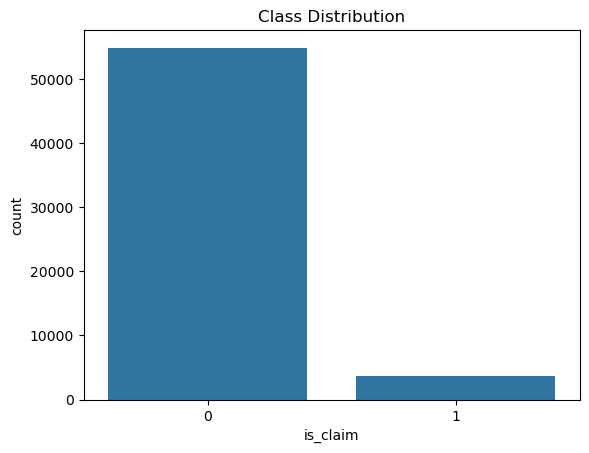

In [26]:
# check for imbalance

import seaborn as sns
import matplotlib.pyplot as plt

# Check for class imbalance
sns.countplot(x=y)
plt.title('Class Distribution')
# Save the plot as a PDF
plt.savefig('synthetic_premium_distribution 2.pdf') 
plt.show()


In [28]:
from imblearn.over_sampling import SMOTE

# Oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model on the resampled data
driver_behavior_model.fit(X_resampled, y_resampled)

# Predict and evaluate the model
y_pred = driver_behavior_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.95      0.57      0.71     10963
           1       0.08      0.56      0.14       756

    accuracy                           0.57     11719
   macro avg       0.52      0.56      0.43     11719
weighted avg       0.89      0.57      0.67     11719



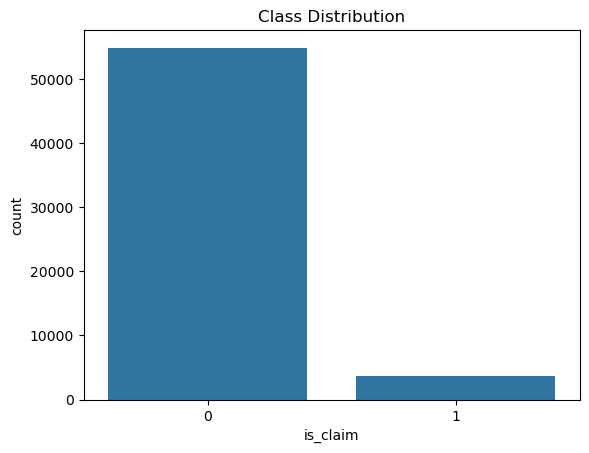

In [30]:
# check for imbalance

import seaborn as sns
import matplotlib.pyplot as plt

# Check for class imbalance
sns.countplot(x=y)
plt.title('Class Distribution')
# Save the plot as a PDF
plt.savefig('synthetic_premium_distribution 3.pdf') 
plt.show()

In [32]:
#developing a Streamlit dashboard that incorporates the following functionalities
#step 1: Update Preprocessing Pipeline


import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Define numerical and categorical features
numerical_features = [
    'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density',
    'airbags', 'displacement', 'cylinder', 'gear_box', 'turning_radius',
    'length', 'width', 'height', 'gross_weight', 'ncap_rating'
]
categorical_features = [
    'make', 'segment', 'model', 'fuel_type', 'is_esc', 'is_adjustable_steering',
    'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
    'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert'
]

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')


['preprocessor.pkl']

In [34]:
#Step 2: Train and Save Models

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Load the data
train = pd.read_csv('train.csv')

# Separate features and target
X_train = train.drop(columns=['is_claim', 'policy_id'])
y_train = train['is_claim']

# Preprocess the data
preprocessor = joblib.load('preprocessor.pkl')
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# Train the risk assessment model
risk_model = RandomForestClassifier(random_state=42)
risk_model.fit(X_train_smote, y_train_smote)

# Save the risk model
joblib.dump(risk_model, 'risk_model.pkl')


['risk_model.pkl']

In [38]:
#Premium Estimation Model

from sklearn.linear_model import LinearRegression

# Generate synthetic premiums based on risk score
train['risk_score'] = risk_model.predict_proba(X_train_preprocessed)[:, 1]
train['synthetic_premium'] = 500 + 1500 * train['risk_score']

# Train the premium estimation model
premium_model = LinearRegression()
premium_model.fit(train[['risk_score']], train['synthetic_premium'])

# Save the premium model
joblib.dump(premium_model, 'premium_model.pkl')


['premium_model.pkl']

In [40]:
#Step 3: Develop the Streamlit Dashboard

import streamlit as st
import joblib
import pandas as pd

# Load the models and preprocessor
preprocessor = joblib.load('preprocessor.pkl')
risk_model = joblib.load('risk_model.pkl')
premium_model = joblib.load('premium_model.pkl')

# Title
st.title("Insurance Dashboard")

# Input Form
st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", ['Make1', 'Make2', 'Make3'])
# ... (Add other input fields similarly)

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    # ... (Add other input fields similarly)
}

input_df = pd.DataFrame(input_data)

# Preprocess the input data
input_preprocessed = preprocessor.transform(input_df)

# Predict Claim
claim_prediction = risk_model.predict(input_preprocessed)
claim_probability = risk_model.predict_proba(input_preprocessed)[:, 1]

# Predict Premium
premium_estimation = premium_model.predict(pd.DataFrame({'risk_score': claim_probability}))

# Display results
st.header("Results")
st.write(f"Claim Prediction: {'Yes' if claim_prediction[0] else 'No'}")
st.write(f"Risk Score: {claim_probability[0]:.4f}")
st.write(f"Estimated Premium: ${premium_estimation[0]:.2f}")

# Add more sections for driver behavior prediction if needed
# st.header("Driver Behavior")
# ... (Add driver behavior prediction logic and display results)


2024-08-01 20:44:40.192 
  command:

    streamlit run C:\Users\JOELM\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [50]:
#update8 

import streamlit as st
import joblib
import pandas as pd

# Load the models and preprocessors
preprocessor_claim = joblib.load('preprocessor.pkl')
risk_model = joblib.load('risk_model.pkl')
premium_model = joblib.load('premium_model.pkl')
preprocessor_behavior = joblib.load('preprocessor_driver_behavior.pkl')
driver_behavior_model = joblib.load('driver_behavior_model.pkl')

# Title
st.title("Insurance Dashboard")

#  Load the dataset for unique values in selectbox inputs
df = pd.read_csv('train.csv')

# Input Form
st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", df['make'].unique())
segment = st.selectbox("Segment", df['segment'].unique())
model = st.selectbox("Model", df['model'].unique())
fuel_type = st.selectbox("Fuel Type", df['fuel_type'].unique())
airbags = st.number_input("Number of Airbags", min_value=0, max_value=10)
is_esc = st.selectbox("ESC (Electronic Stability Control)", [0, 1])
is_adjustable_steering = st.selectbox("Adjustable Steering", [0, 1])
is_tpms = st.selectbox("TPMS (Tire Pressure Monitoring System)", [0, 1])
is_parking_sensors = st.selectbox("Parking Sensors", [0, 1])
is_parking_camera = st.selectbox("Parking Camera", [0, 1])
rear_brakes_type = st.selectbox("Rear Brakes Type", df['rear_brakes_type'].unique())
displacement = st.number_input("Displacement (cc)", min_value=0, max_value=5000)
cylinder = st.number_input("Number of Cylinders", min_value=0, max_value=16)
transmission_type = st.selectbox("Transmission Type", df['transmission_type'].unique())
gear_box = st.number_input("Number of Gears", min_value=0, max_value=10)
steering_type = st.selectbox("Steering Type", df['steering_type'].unique())
turning_radius = st.number_input("Turning Radius (m)", min_value=0.0, max_value=15.0)
length = st.number_input("Length (mm)", min_value=0, max_value=5000)
width = st.number_input("Width (mm)", min_value=0, max_value=3000)
height = st.number_input("Height (mm)", min_value=0, max_value=3000)
gross_weight = st.number_input("Gross Weight (kg)", min_value=0, max_value=5000)
is_front_fog_lights = st.selectbox("Front Fog Lights", [0, 1])
is_rear_window_wiper = st.selectbox("Rear Window Wiper", [0, 1])
is_rear_window_washer = st.selectbox("Rear Window Washer", [0, 1])
is_rear_window_defogger = st.selectbox("Rear Window Defogger", [0, 1])
is_brake_assist = st.selectbox("Brake Assist", [0, 1])
is_power_door_locks = st.selectbox("Power Door Locks", [0, 1])
is_central_locking = st.selectbox("Central Locking", [0, 1])
is_power_steering = st.selectbox("Power Steering", [0, 1])
is_driver_seat_height_adjustable = st.selectbox("Driver Seat Height Adjustable", [0, 1])
is_day_night_rear_view_mirror = st.selectbox("Day/Night Rear View Mirror", [0, 1])
is_ecw = st.selectbox("ECW (Emergency Call Warning)", [0, 1])
is_speed_alert = st.selectbox("Speed Alert", [0, 1])
ncap_rating = st.selectbox("ncap_rating", [0, 1])

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    'segment': [segment],
    'model': [model],
    'fuel_type': [fuel_type],
    'airbags': [airbags],
    'is_esc': [is_esc],
    'is_adjustable_steering': [is_adjustable_steering],
    'is_tpms': [is_tpms],
    'is_parking_sensors': [is_parking_sensors],
    'is_parking_camera': [is_parking_camera],
    'rear_brakes_type': [rear_brakes_type],
    'displacement': [displacement],
    'cylinder': [cylinder],
    'transmission_type': [transmission_type],
    'gear_box': [gear_box],
    'steering_type': [steering_type],
    'turning_radius': [turning_radius],
    'length': [length],
    'width': [width],
    'height': [height],
    'gross_weight': [gross_weight],
    'is_front_fog_lights': [is_front_fog_lights],
    'is_rear_window_wiper': [is_rear_window_wiper],
    'is_rear_window_washer': [is_rear_window_washer],
    'is_rear_window_defogger': [is_rear_window_defogger],
    'is_brake_assist': [is_brake_assist],
    'is_power_door_locks': [is_power_door_locks],
    'is_central_locking': [is_central_locking],
    'is_power_steering': [is_power_steering],
    'is_driver_seat_height_adjustable': [is_driver_seat_height_adjustable],
    'is_day_night_rear_view_mirror': [is_day_night_rear_view_mirror],
    'is_ecw': [is_ecw],
    'is_speed_alert': [is_speed_alert],
    'ncap_rating': [ncap_rating]
}

input_df = pd.DataFrame(input_data)

# Preprocess the input data
input_preprocessed_claim = preprocessor_claim.transform(input_df)
input_preprocessed_behavior = preprocessor_behavior.transform(input_df)

# Predict Claim
claim_prediction = risk_model.predict(input_preprocessed_claim)
claim_probability = risk_model.predict_proba(input_preprocessed_claim)[:, 1]

# Predict Premium
premium_estimation = premium_model.predict(pd.DataFrame({'risk_score': claim_probability}))

# Predict Driver Behavior
behavior_prediction = driver_behavior_model.predict(input_preprocessed_behavior)
behavior_probability = driver_behavior_model.predict_proba(input_preprocessed_behavior)[:, 1]

# Display results
st.header("Results")
st.write(f"Claim Prediction: {'Yes' if claim_prediction[0] else 'No'}")
st.write(f"Risk Score: {claim_probability[0]:.4f}")
st.write(f"Estimated Premium: ${premium_estimation[0]:.2f}")
st.write(f"Driver Behavior Prediction: {'Risky' if behavior_prediction[0] else 'Safe'}")
st.write(f"Behavior Risk Score: {behavior_probability[0]:.4f}")


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [52]:
# Fit the preprocessor on the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [54]:
# Load the fitted preprocessor
preprocessor_claim = joblib.load('preprocessor.pkl')

# Now you can transform the input data
input_preprocessed_claim = preprocessor_claim.transform(input_df)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib

# Define numerical and categorical features
numerical_features = [
    'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density',
    'airbags', 'displacement', 'cylinder', 'gear_box', 'turning_radius',
    'length', 'width', 'height', 'gross_weight', 'ncap_rating'
]
categorical_features = [
    'make', 'segment', 'model', 'fuel_type', 'is_esc', 'is_adjustable_steering',
    'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
    'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert'
]

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')


['preprocessor.pkl']

In [58]:
# *Step 2: Train and Save Your Models*
#*Example for Risk Model:*

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib

# Load the data
train = pd.read_csv('train.csv')

# Separate features and target
X_train = train.drop(columns=['is_claim', 'policy_id'])
y_train = train['is_claim']

# Preprocess the data
preprocessor = joblib.load('preprocessor.pkl')
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# Train the risk assessment model
risk_model = RandomForestClassifier(random_state=42)
risk_model.fit(X_train_smote, y_train_smote)

# Save the risk model
joblib.dump(risk_model, 'risk_model.pkl')



['risk_model.pkl']

In [60]:
#*Example for Premium Estimation Model:*

from sklearn.linear_model import LinearRegression
import joblib

# Generate synthetic premiums based on risk score
train['risk_score'] = risk_model.predict_proba(X_train_preprocessed)[:, 1]
train['synthetic_premium'] = 500 + 1500 * train['risk_score']

# Train the premium estimation model
premium_model = LinearRegression()
premium_model.fit(train[['risk_score']], train['synthetic_premium'])

# Save the premium model
joblib.dump(premium_model, 'premium_model.pkl')

['premium_model.pkl']

In [62]:
#*Example for Driver Behavior Model:*

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Train the logistic regression model
driver_behavior_model = LogisticRegression(random_state=42)
driver_behavior_model.fit(X_train, y_train)

# Save the driver behavior model
joblib.dump(driver_behavior_model, 'driver_behavior_model.pkl')


['driver_behavior_model.pkl']

In [76]:
import streamlit as st
import joblib
import pandas as pd

# Load the models and preprocessors
preprocessor_claim = joblib.load('preprocessor.pkl')
claim_model = joblib.load('final_lr_smote_model.pkl')
premium_model = joblib.load('premium_model.pkl')
preprocessor_behavior = joblib.load('preprocessor_driver_behavior.pkl')
driver_behavior_model = joblib.load('driver_behavior_model.pkl')

# Title
st.title("Insurance Dashboard")

# Load the dataset for unique values in selectbox inputs
df = pd.read_csv('train.csv')

# Input Form
st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", df['make'].unique())
segment = st.selectbox("Segment", df['segment'].unique())
model = st.selectbox("Model", df['model'].unique())
fuel_type = st.selectbox("Fuel Type", df['fuel_type'].unique())
airbags = st.number_input("Number of Airbags", min_value=0, max_value=10)
is_esc = st.selectbox("ESC (Electronic Stability Control)", [0, 1])
is_adjustable_steering = st.selectbox("Adjustable Steering", [0, 1])
is_tpms = st.selectbox("TPMS (Tire Pressure Monitoring System)", [0, 1])
is_parking_sensors = st.selectbox("Parking Sensors", [0, 1])
is_parking_camera = st.selectbox("Parking Camera", [0, 1])
rear_brakes_type = st.selectbox("Rear Brakes Type", df['rear_brakes_type'].unique())
displacement = st.number_input("Displacement (cc)", min_value=0, max_value=5000)
cylinder = st.number_input("Number of Cylinders", min_value=0, max_value=16)
transmission_type = st.selectbox("Transmission Type", df['transmission_type'].unique())
gear_box = st.number_input("Number of Gears", min_value=0, max_value=10)
steering_type = st.selectbox("Steering Type", df['steering_type'].unique())
turning_radius = st.number_input("Turning Radius (m)", min_value=0.0, max_value=15.0)
length = st.number_input("Length (mm)", min_value=0, max_value=5000)
width = st.number_input("Width (mm)", min_value=0, max_value=3000)
height = st.number_input("Height (mm)", min_value=0, max_value=3000)
gross_weight = st.number_input("Gross Weight (kg)", min_value=0, max_value=5000)
is_front_fog_lights = st.selectbox("Front Fog Lights", [0, 1])
is_rear_window_wiper = st.selectbox("Rear Window Wiper", [0, 1])
is_rear_window_washer = st.selectbox("Rear Window Washer", [0, 1])
is_rear_window_defogger = st.selectbox("Rear Window Defogger", [0, 1])
is_brake_assist = st.selectbox("Brake Assist", [0, 1])
is_power_door_locks = st.selectbox("Power Door Locks", [0, 1])
is_central_locking = st.selectbox("Central Locking", [0, 1])
is_power_steering = st.selectbox("Power Steering", [0, 1])
is_driver_seat_height_adjustable = st.selectbox("Driver Seat Height Adjustable", [0, 1])
is_day_night_rear_view_mirror = st.selectbox("Day/Night Rear View Mirror", [0, 1])
is_ecw = st.selectbox("ECW (Emergency Call Warning)", [0, 1])
is_speed_alert = st.selectbox("Speed Alert", [0, 1])
ncap_rating = st.selectbox("ncap_rating", [0, 1])

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    'segment': [segment],
    'model': [model],
    'fuel_type': [fuel_type],
    'airbags': [airbags],
    'is_esc': [is_esc],
    'is_adjustable_steering': [is_adjustable_steering],
    'is_tpms': [is_tpms],
    'is_parking_sensors': [is_parking_sensors],
    'is_parking_camera': [is_parking_camera],
    'rear_brakes_type': [rear_brakes_type],
    'displacement': [displacement],
    'cylinder': [cylinder],
    'transmission_type': [transmission_type],
    'gear_box': [gear_box],
    'steering_type': [steering_type],
    'turning_radius': [turning_radius],
    'length': [length],
    'width': [width],
    'height': [height],
    'gross_weight': [gross_weight],
    'is_front_fog_lights': [is_front_fog_lights],
    'is_rear_window_wiper': [is_rear_window_wiper],
    'is_rear_window_washer': [is_rear_window_washer],
    'is_rear_window_defogger': [is_rear_window_defogger],
    'is_brake_assist': [is_brake_assist],
    'is_power_door_locks': [is_power_door_locks],
    'is_central_locking': [is_central_locking],
    'is_power_steering': [is_power_steering],
    'is_driver_seat_height_adjustable': [is_driver_seat_height_adjustable],
    'is_day_night_rear_view_mirror': [is_day_night_rear_view_mirror],
    'is_ecw': [is_ecw],
    'is_speed_alert': [is_speed_alert],
    'ncap_rating': [ncap_rating]
}

input_df = pd.DataFrame(input_data)

# Ensure all columns required by the preprocessor are present
for col in numerical_features + categorical_features:
    if col not in input_df.columns:
        input_df[col] = 0  # Or another default value

# Preprocess the input data for claim prediction
if input_df.empty:
    st.error("No input data provided. Please fill in the required fields.")
    input_preprocessed_claim = None  # Define the variable but set it to None
else:
    try:
        input_preprocessed_claim = preprocessor_claim.transform(input_df)
    except Exception as e:
        st.error(f"Error in preprocessing: {e}")
        input_preprocessed_claim = None

# Predict Claim only if preprocessing was successful
if input_preprocessed_claim is not None:
    claim_prediction = claim_model.predict(input_preprocessed_claim)
    claim_probability = claim_model.predict_proba(input_preprocessed_claim)[:, 1]
else:
    claim_prediction = [None]
    claim_probability = [None]

# Preprocess the input data for driver behavior prediction
if input_df.empty:
    input_preprocessed_behavior = None  # Define the variable but set it to None
else:
    try:
        input_preprocessed_behavior = preprocessor_behavior.transform(input_df)
    except Exception as e:
        st.error(f"Error in preprocessing driver behavior data: {e}")
        input_preprocessed_behavior = None

# Predict Driver Behavior only if preprocessing was successful
if input_preprocessed_behavior is not None:
    behavior_prediction = driver_behavior_model.predict(input_preprocessed_behavior)
    behavior_probability = driver_behavior_model.predict_proba(input_preprocessed_behavior)[:, 1]
else:
    behavior_prediction = [None]
    behavior_probability = [None]

# Predict Premium only if claim probability is available
if claim_probability[0] is not None:
    premium_estimation = premium_model.predict(pd.DataFrame({'risk_score': claim_probability}))
else:
    premium_estimation = [None]

# Display results
st.header("Results")
if claim_prediction[0] is not None:
    st.write(f"Claim Prediction: {'Yes' if claim_prediction[0] else 'No'}")
    st.write(f"Risk Score: {claim_probability[0]:.4f}")
    st.write(f"Estimated Premium: ${premium_estimation[0]:.2f}")
else:
    st.write("Claim Prediction: N/A")

if behavior_prediction[0] is not None:
    st.write(f"Driver Behavior Prediction: {'Risky' if behavior_prediction[0] else 'Safe'}")
    st.write(f"Behavior Risk Score: {behavior_probability[0]:.4f}")
else:
    st.write("Driver Behavior Prediction: N/A")


In [78]:
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Load the training data
train = pd.read_csv('train.csv')

# Define numerical and categorical features
numerical_features = [
    'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density',
    'airbags', 'displacement', 'cylinder', 'gear_box', 'turning_radius',
    'length', 'width', 'height', 'gross_weight', 'ncap_rating'
]
categorical_features = [
    'make', 'segment', 'model', 'fuel_type', 'is_esc', 'is_adjustable_steering',
    'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
    'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert'
]

# Create the column transformer
preprocessor_claim = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Separate features and target from the training data
X_train = train.drop(columns=['is_claim', 'policy_id'])
y_train = train['is_claim']

# Fit the preprocessor on the training data
preprocessor_claim.fit(X_train)

# Save the fitted preprocessor
joblib.dump(preprocessor_claim, 'preprocessor.pkl')

['preprocessor.pkl']

In [80]:
# Load the fitted preprocessor
preprocessor_claim = joblib.load('preprocessor.pkl')

# Now you can transform the input data
input_preprocessed_claim = preprocessor_claim.transform(input_df)

# Proceed with the prediction
claim_prediction = claim_model.predict(input_preprocessed_claim)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [4]:
#Step 1: Preprocessing
#Define Numerical and Categorical Features: Identify the numerical and categorical columns in your dataset.
#Create a Column Transformer: Use ColumnTransformer to apply StandardScaler to numerical features and OneHotEncoder to categorical features.
#Fit and Save the Preprocessor: Fit the preprocessor to the training data and save it using joblib.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import joblib

# Load the training data
train = pd.read_csv('train.csv')

# Define numerical and categorical features
numerical_features = [
    'policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density',
    'airbags', 'displacement', 'cylinder', 'gear_box', 'turning_radius',
    'length', 'width', 'height', 'gross_weight', 'ncap_rating'
]
categorical_features = [
    'make', 'segment', 'model', 'fuel_type', 'is_esc', 'is_adjustable_steering',
    'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
    'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
    'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
    'is_power_door_locks', 'is_central_locking', 'is_power_steering',
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
    'is_ecw', 'is_speed_alert', 'area_cluster', 'max_torque',
    'max_power', 'engine_type'
]

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Separate features and target from the training data
X_train = train.drop(columns=['is_claim', 'policy_id'])
y_train = train['is_claim']

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'ubi_preprocessor.pkl')
joblib.dump(X_train.columns.tolist(), 'ubi_columns.pkl')

# Transform the training data
X_train_preprocessed = preprocessor.transform(X_train)
pd.DataFrame(X_train_preprocessed).to_csv('X_train_preprocessed.csv', index=False)

In [6]:
#Step 2a: Train and Save Models
#Claim Prediction Model
#Train and save the logistic regression model for claim prediction, ensuring to use SMOTE for balancing the classes.

import pandas as pd
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib

# Load the training and testing data
X_train = pd.read_csv('X_train_preprocessed.csv')
y_train = pd.read_csv('y_train.csv')['is_claim']
X_test = pd.read_csv('X_test_preprocessed.csv')
y_test = pd.read_csv('y_test.csv')['is_claim']

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the logistic regression model with the best parameters
best_lr_params = {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
model_lr_smote = LogisticRegression(**best_lr_params)
model_lr_smote.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = model_lr_smote.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Logistic Regression with SMOTE (Best Parameters) - Test Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(model_lr_smote, 'ubi_final_lr_smote_model.pkl')


Logistic Regression with SMOTE (Best Parameters) - Test Set Metrics:
Accuracy: 0.5766
Precision: 0.0793
Recall: 0.5293
F1-score: 0.1379

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     10969
           1       0.08      0.53      0.14       750

    accuracy                           0.58     11719
   macro avg       0.51      0.55      0.43     11719
weighted avg       0.89      0.58      0.68     11719



['ubi_final_lr_smote_model.pkl']

In [8]:
#Step 2b: Train and Save Models
#Risk Model: Train a model to predict the risk of a claim.
#Premium Estimation Model: Train a model to estimate insurance premiums.
#Driver Behavior Model: Train a model to assess driver behavior.

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib

# Load the preprocessor
preprocessor = joblib.load('ubi_preprocessor.pkl')

# Preprocess the training data
X_train_preprocessed = preprocessor.transform(X_train)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# Train the risk assessment model
risk_model = RandomForestClassifier(random_state=42)
risk_model.fit(X_train_smote, y_train_smote)

# Save the risk model
joblib.dump(risk_model, 'ubi_risk_model.pkl')


ValueError: columns are missing: {'age_of_policyholder', 'length', 'airbags', 'ncap_rating', 'is_tpms', 'policy_tenure', 'is_adjustable_steering', 'is_parking_camera', 'model', 'is_ecw', 'age_of_car', 'make', 'cylinder', 'is_rear_window_washer', 'is_brake_assist', 'gear_box', 'steering_type', 'population_density', 'segment', 'is_parking_sensors', 'height', 'is_central_locking', 'is_rear_window_defogger', 'width', 'is_esc', 'is_power_steering', 'is_speed_alert', 'transmission_type', 'displacement', 'gross_weight', 'is_day_night_rear_view_mirror', 'rear_brakes_type', 'is_driver_seat_height_adjustable', 'turning_radius', 'fuel_type', 'is_rear_window_wiper', 'is_front_fog_lights', 'is_power_door_locks'}

In [14]:
#claim prediction

import pandas as pd
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import joblib

# Load the column names used during training
columns = joblib.load('ubi_columns.pkl')

# Load the training data
X_train = pd.read_csv('train.csv')[columns]
y_train = pd.read_csv('train.csv')['is_claim']

# Preprocess the training data
preprocessor = joblib.load('ubi_preprocessor.pkl')
X_train_preprocessed = preprocessor.transform(X_train)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Train the logistic regression model
best_lr_params = {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
model_lr_smote = LogisticRegression(**best_lr_params)
model_lr_smote.fit(X_train_resampled, y_train_resampled)

# Save the model
joblib.dump(model_lr_smote, 'ubi_final_lr_smote_model.pkl')


['ubi_final_lr_smote_model.pkl']

In [22]:
#Risk Model

# Load the column names used during training
columns = joblib.load('ubi_columns.pkl')

# Load the training data
X_train = pd.read_csv('train.csv')[columns]
y_train = pd.read_csv('train.csv')['is_claim']

# Preprocess the training data
preprocessor = joblib.load('ubi_preprocessor.pkl')
X_train_preprocessed = preprocessor.transform(X_train)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Train the logistic regression model for risk
best_lr_params = {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
risk_model = LogisticRegression(**best_lr_params)
risk_model.fit(X_train_resampled, y_train_resampled)

# Save the risk model
joblib.dump(risk_model, 'ubi_risk_model.pkl')


['ubi_risk_model.pkl']

In [24]:
#Premium Estimation

# Load the column names used during training
columns = joblib.load('ubi_columns.pkl')

# Load the training data
X_train = pd.read_csv('train.csv')[columns]
y_train = pd.read_csv('train.csv')['is_claim']

# Preprocess the training data
preprocessor = joblib.load('ubi_preprocessor.pkl')
X_train_preprocessed = preprocessor.transform(X_train)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Train the model for premium estimation
premium_model = LogisticRegression()  # Replace with the actual model used for premium estimation
premium_model.fit(X_train_resampled, y_train_resampled)

# Save the premium model
joblib.dump(premium_model, 'ubi_premium_model.pkl')



['ubi_premium_model.pkl']

In [28]:
#Driver Behavior

# Load the column names used during training
columns = joblib.load('ubi_columns.pkl')

# Load the training data
X_train = pd.read_csv('train.csv')[columns]
y_train = pd.read_csv('train.csv')['is_claim']

# Preprocess the training data
preprocessor = joblib.load('ubi_preprocessor.pkl')
X_train_preprocessed = preprocessor.transform(X_train)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Train the model for driver behavior
driver_behavior_model = LogisticRegression()  # Replace with the actual model used for driver behavior assessment
driver_behavior_model.fit(X_train_resampled, y_train_resampled)

# Save the driver behavior model
joblib.dump(driver_behavior_model, 'ubi_driver_behavior_model.pkl')


['ubi_driver_behavior_model.pkl']

In [32]:
import streamlit as st
import joblib
import pandas as pd

# Load the preprocessor, models, and columns
preprocessor = joblib.load('ubi_preprocessor.pkl')
claim_model = joblib.load('ubi_final_lr_smote_model.pkl')
risk_model = joblib.load('ubi_risk_model.pkl')
premium_model = joblib.load('ubi_premium_model.pkl')
driver_behavior_model = joblib.load('ubi_driver_behavior_model.pkl')
columns = joblib.load('ubi_columns.pkl')

# Title
st.title("Insurance Dashboard")

# Load the dataset for unique values in selectbox inputs
df = pd.read_csv('train.csv')

# Input Form
st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", df['make'].unique())
segment = st.selectbox("Segment", df['segment'].unique())
model = st.selectbox("Model", df['model'].unique())
fuel_type = st.selectbox("Fuel Type", df['fuel_type'].unique())
airbags = st.number_input("Number of Airbags", min_value=0, max_value=10)
is_esc = st.selectbox("ESC (Electronic Stability Control)", [0, 1])
is_adjustable_steering = st.selectbox("Adjustable Steering", [0, 1])
is_tpms = st.selectbox("TPMS (Tire Pressure Monitoring System)", [0, 1])
is_parking_sensors = st.selectbox("Parking Sensors", [0, 1])
is_parking_camera = st.selectbox("Parking Camera", [0, 1])
rear_brakes_type = st.selectbox("Rear Brakes Type", df['rear_brakes_type'].unique())
displacement = st.number_input("Displacement (cc)", min_value=0, max_value=5000)
cylinder = st.number_input("Number of Cylinders", min_value=0, max_value=16)
transmission_type = st.selectbox("Transmission Type", df['transmission_type'].unique())
gear_box = st.number_input("Number of Gears", min_value=0, max_value=10)
steering_type = st.selectbox("Steering Type", df['steering_type'].unique())
turning_radius = st.number_input("Turning Radius (m)", min_value=0.0, max_value=15.0)
length = st.number_input("Length (mm)", min_value=0, max_value=5000)
width = st.number_input("Width (mm)", min_value=0, max_value=3000)
height = st.number_input("Height (mm)", min_value=0, max_value=3000)
gross_weight = st.number_input("Gross Weight (kg)", min_value=0, max_value=5000)
is_front_fog_lights = st.selectbox("Front Fog Lights", [0, 1])
is_rear_window_wiper = st.selectbox("Rear Window Wiper", [0, 1])
is_rear_window_washer = st.selectbox("Rear Window Washer", [0, 1])
is_rear_window_defogger = st.selectbox("Rear Window Defogger", [0, 1])
is_brake_assist = st.selectbox("Brake Assist", [0, 1])
is_power_door_locks = st.selectbox("Power Door Locks", [0, 1])
is_central_locking = st.selectbox("Central Locking", [0, 1])
is_power_steering = st.selectbox("Power Steering", [0, 1])
is_driver_seat_height_adjustable = st.selectbox("Driver Seat Height Adjustable", [0, 1])
is_day_night_rear_view_mirror = st.selectbox("Day/Night Rear View Mirror", [0, 1])
is_ecw = st.selectbox("ECW (Emergency Call Warning)", [0, 1])
is_speed_alert = st.selectbox("Speed Alert", [0, 1])
ncap_rating = st.selectbox("NCAP Rating", df['ncap_rating'].unique())

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    'segment': [segment],
    'model': [model],
    'fuel_type': [fuel_type],
    'airbags': [airbags],
    'is_esc': [is_esc],
    'is_adjustable_steering': [is_adjustable_steering],
    'is_tpms': [is_tpms],
    'is_parking_sensors': [is_parking_sensors],
    'is_parking_camera': [is_parking_camera],
    'rear_brakes_type': [rear_brakes_type],
    'displacement': [displacement],
    'cylinder': [cylinder],
    'transmission_type': [transmission_type],
    'gear_box': [gear_box],
    'steering_type': [steering_type],
    'turning_radius': [turning_radius],
    'length': [length],
    'width': [width],
    'height': [height],
    'gross_weight': [gross_weight],
    'is_front_fog_lights': [is_front_fog_lights],
    'is_rear_window_wiper': [is_rear_window_wiper],
    'is_rear_window_washer': [is_rear_window_washer],
    'is_rear_window_defogger': [is_rear_window_defogger],
    'is_brake_assist': [is_brake_assist],
    'is_power_door_locks': [is_power_door_locks],
    'is_central_locking': [is_central_locking],
    'is_power_steering': [is_power_steering],
    'is_driver_seat_height_adjustable': [is_driver_seat_height_adjustable],
    'is_day_night_rear_view_mirror': [is_day_night_rear_view_mirror],
    'is_ecw': [is_ecw],
    'is_speed_alert': [is_speed_alert],
    'ncap_rating': [ncap_rating]
}

input_df = pd.DataFrame(input_data, columns=columns)

# Preprocess the input data
input_preprocessed = preprocessor.transform(input_df)

# Predict claim risk
claim_risk_prediction = claim_model.predict(input_preprocessed)
st.write(f"Claim Risk Prediction: {'Yes' if claim_risk_prediction[0] == 1 else 'No'}")

# Predict premium
premium_prediction = premium_model.predict(claim_risk_prediction.reshape(-1, 1))
st.write(f"Estimated Premium: ${premium_prediction[0]:.2f}")

# Assess driver behavior
driver_behavior_features = [feature for feature in columns if feature not in ['premium', 'risk', 'driver_behavior']]
driver_behavior_prediction = driver_behavior_model.predict(input_preprocessed[driver_behavior_features])
st.write(f"Driver Behavior Assessment: {'Good' if driver_behavior_prediction[0] == 0 else 'Bad'}")


2024-08-03 10:21:08.009 
  command:

    streamlit run C:\Users\JOELM\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [34]:
import streamlit as st
import joblib
import pandas as pd
import numpy as np

# Load the preprocessor, models, and columns
preprocessor = joblib.load('ubi_preprocessor.pkl')
claim_model = joblib.load('ubi_final_lr_smote_model.pkl')
risk_model = joblib.load('ubi_risk_model.pkl')
premium_model = joblib.load('ubi_premium_model.pkl')
driver_behavior_model = joblib.load('ubi_driver_behavior_model.pkl')
columns = joblib.load('ubi_columns.pkl')

# Title
st.title("Insurance Dashboard")

# Load the dataset for unique values in selectbox inputs
df = pd.read_csv('train.csv')

# Input Form
st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", df['make'].unique())
segment = st.selectbox("Segment", df['segment'].unique())
model = st.selectbox("Model", df['model'].unique())
fuel_type = st.selectbox("Fuel Type", df['fuel_type'].unique())
airbags = st.number_input("Number of Airbags", min_value=0, max_value=10)
is_esc = st.selectbox("ESC (Electronic Stability Control)", [0, 1])
is_adjustable_steering = st.selectbox("Adjustable Steering", [0, 1])
is_tpms = st.selectbox("TPMS (Tire Pressure Monitoring System)", [0, 1])
is_parking_sensors = st.selectbox("Parking Sensors", [0, 1])
is_parking_camera = st.selectbox("Parking Camera", [0, 1])
rear_brakes_type = st.selectbox("Rear Brakes Type", df['rear_brakes_type'].unique())
displacement = st.number_input("Displacement (cc)", min_value=0, max_value=5000)
cylinder = st.number_input("Number of Cylinders", min_value=0, max_value=16)
transmission_type = st.selectbox("Transmission Type", df['transmission_type'].unique())
gear_box = st.number_input("Number of Gears", min_value=0, max_value=10)
steering_type = st.selectbox("Steering Type", df['steering_type'].unique())
turning_radius = st.number_input("Turning Radius (m)", min_value=0.0, max_value=15.0)
length = st.number_input("Length (mm)", min_value=0, max_value=5000)
width = st.number_input("Width (mm)", min_value=0, max_value=3000)
height = st.number_input("Height (mm)", min_value=0, max_value=3000)
gross_weight = st.number_input("Gross Weight (kg)", min_value=0, max_value=5000)
is_front_fog_lights = st.selectbox("Front Fog Lights", [0, 1])
is_rear_window_wiper = st.selectbox("Rear Window Wiper", [0, 1])
is_rear_window_washer = st.selectbox("Rear Window Washer", [0, 1])
is_rear_window_defogger = st.selectbox("Rear Window Defogger", [0, 1])
is_brake_assist = st.selectbox("Brake Assist", [0, 1])
is_power_door_locks = st.selectbox("Power Door Locks", [0, 1])
is_central_locking = st.selectbox("Central Locking", [0, 1])
is_power_steering = st.selectbox("Power Steering", [0, 1])
is_driver_seat_height_adjustable = st.selectbox("Driver Seat Height Adjustable", [0, 1])
is_day_night_rear_view_mirror = st.selectbox("Day/Night Rear View Mirror", [0, 1])
is_ecw = st.selectbox("ECW (Emergency Call Warning)", [0, 1])
is_speed_alert = st.selectbox("Speed Alert", [0, 1])
ncap_rating = st.selectbox("NCAP Rating", df['ncap_rating'].unique())

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    'segment': [segment],
    'model': [model],
    'fuel_type': [fuel_type],
    'airbags': [airbags],
    'is_esc': [is_esc],
    'is_adjustable_steering': [is_adjustable_steering],
    'is_tpms': [is_tpms],
    'is_parking_sensors': [is_parking_sensors],
    'is_parking_camera': [is_parking_camera],
    'rear_brakes_type': [rear_brakes_type],
    'displacement': [displacement],
    'cylinder': [cylinder],
    'transmission_type': [transmission_type],
    'gear_box': [gear_box],
    'steering_type': [steering_type],
    'turning_radius': [turning_radius],
    'length': [length],
    'width': [width],
    'height': [height],
    'gross_weight': [gross_weight],
    'is_front_fog_lights': [is_front_fog_lights],
    'is_rear_window_wiper': [is_rear_window_wiper],
    'is_rear_window_washer': [is_rear_window_washer],
    'is_rear_window_defogger': [is_rear_window_defogger],
    'is_brake_assist': [is_brake_assist],
    'is_power_door_locks': [is_power_door_locks],
    'is_central_locking': [is_central_locking],
    'is_power_steering': [is_power_steering],
    'is_driver_seat_height_adjustable': [is_driver_seat_height_adjustable],
    'is_day_night_rear_view_mirror': [is_day_night_rear_view_mirror],
    'is_ecw': [is_ecw],
    'is_speed_alert': [is_speed_alert],
    'ncap_rating': [ncap_rating]
}

input_df = pd.DataFrame(input_data)

# Ensure input columns are in the correct order
input_df = input_df[columns]

# Check data types
input_df = input_df.astype({col: 'object' for col in input_df.select_dtypes('category').columns})

# Preprocess the input data
input_preprocessed = preprocessor.transform(input_df)

# Predict claim risk
claim_risk_prediction = claim_model.predict(input_preprocessed)
st.write(f"Claim Risk Prediction: {'Yes' if claim_risk_prediction[0] == 1 else 'No'}")

# Predict premium
premium_prediction = premium_model.predict(claim_risk_prediction.reshape(-1, 1))
st.write(f"Estimated Premium: ${premium_prediction[0]:.2f}")

# Assess driver behavior
driver_behavior_features = [feature for feature in columns if feature not in ['premium', 'risk', 'driver_behavior']]
driver_behavior_prediction = driver_behavior_model.predict(input_preprocessed[driver_behavior_features])
st.write(f"Driver Behavior Assessment: {'Good' if driver_behavior_prediction[0] == 0 else 'Bad'}")


KeyError: "['area_cluster', 'max_torque', 'max_power', 'engine_type'] not in index"

In [40]:
columns = joblib.load('ubi_columns.pkl')
print(columns)

['policy_tenure', 'age_of_car', 'age_of_policyholder', 'area_cluster', 'population_density', 'make', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power', 'engine_type', 'airbags', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder', 'transmission_type', 'gear_box', 'steering_type', 'turning_radius', 'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert', 'ncap_rating']


In [44]:
print(input_df.columns)

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'make', 'segment', 'model', 'fuel_type',
       'airbags', 'is_esc', 'is_adjustable_steering', 'is_tpms',
       'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type',
       'displacement', 'cylinder', 'transmission_type', 'gear_box',
       'steering_type', 'turning_radius', 'length', 'width', 'height',
       'gross_weight', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating'],
      dtype='object')


In [46]:
import streamlit as st
import joblib
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Load the preprocessor, models, and columns
preprocessor = joblib.load('ubi_preprocessor.pkl')
claim_model = joblib.load('ubi_final_lr_smote_model.pkl')
risk_model = joblib.load('ubi_risk_model.pkl')
premium_model = joblib.load('ubi_premium_model.pkl')
driver_behavior_model = joblib.load('ubi_driver_behavior_model.pkl')
columns = joblib.load('ubi_columns.pkl')

# Title
st.title("Classy Insurance Dashboard")

# Load the dataset for unique values in selectbox inputs
df = pd.read_csv('train.csv')

# Input Form
st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", df['make'].unique())
segment = st.selectbox("Segment", df['segment'].unique())
model = st.selectbox("Model", df['model'].unique())
fuel_type = st.selectbox("Fuel Type", df['fuel_type'].unique())
airbags = st.number_input("Number of Airbags", min_value=0, max_value=10)
is_esc = st.selectbox("ESC (Electronic Stability Control)", [0, 1])
is_adjustable_steering = st.selectbox("Adjustable Steering", [0, 1])
is_tpms = st.selectbox("TPMS (Tire Pressure Monitoring System)", [0, 1])
is_parking_sensors = st.selectbox("Parking Sensors", [0, 1])
is_parking_camera = st.selectbox("Parking Camera", [0, 1])
rear_brakes_type = st.selectbox("Rear Brakes Type", df['rear_brakes_type'].unique())
displacement = st.number_input("Displacement (cc)", min_value=0, max_value=5000)
cylinder = st.number_input("Number of Cylinders", min_value=0, max_value=16)
transmission_type = st.selectbox("Transmission Type", df['transmission_type'].unique())
gear_box = st.number_input("Number of Gears", min_value=0, max_value=10)
steering_type = st.selectbox("Steering Type", df['steering_type'].unique())
turning_radius = st.number_input("Turning Radius (m)", min_value=0.0, max_value=15.0)
length = st.number_input("Length (mm)", min_value=0, max_value=5000)
width = st.number_input("Width (mm)", min_value=0, max_value=3000)
height = st.number_input("Height (mm)", min_value=0, max_value=3000)
gross_weight = st.number_input("Gross Weight (kg)", min_value=0, max_value=5000)
is_front_fog_lights = st.selectbox("Front Fog Lights", [0, 1])
is_rear_window_wiper = st.selectbox("Rear Window Wiper", [0, 1])
is_rear_window_washer = st.selectbox("Rear Window Washer", [0, 1])
is_rear_window_defogger = st.selectbox("Rear Window Defogger", [0, 1])
is_brake_assist = st.selectbox("Brake Assist", [0, 1])
is_power_door_locks = st.selectbox("Power Door Locks", [0, 1])
is_central_locking = st.selectbox("Central Locking", [0, 1])
is_power_steering = st.selectbox("Power Steering", [0, 1])
is_driver_seat_height_adjustable = st.selectbox("Driver Seat Height Adjustable", [0, 1])
is_day_night_rear_view_mirror = st.selectbox("Day/Night Rear View Mirror", [0, 1])
is_ecw = st.selectbox("ECW (Emergency Call Warning)", [0, 1])
is_speed_alert = st.selectbox("Speed Alert", [0, 1])
ncap_rating = st.selectbox("NCAP Rating", df['ncap_rating'].unique())
area_cluster = st.selectbox("Area Cluster", df['area_cluster'].unique())
max_torque = st.selectbox("Max Torque", df['max_torque'].unique())
max_power = st.selectbox("Max Power", df['max_power'].unique())
engine_type = st.selectbox("Engine Type", df['engine_type'].unique())

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    'segment': [segment],
    'model': [model],
    'fuel_type': [fuel_type],
    'airbags': [airbags],
    'is_esc': [is_esc],
    'is_adjustable_steering': [is_adjustable_steering],
    'is_tpms': [is_tpms],
    'is_parking_sensors': [is_parking_sensors],
    'is_parking_camera': [is_parking_camera],
    'rear_brakes_type': [rear_brakes_type],
    'displacement': [displacement],
    'cylinder': [cylinder],
    'transmission_type': [transmission_type],
    'gear_box': [gear_box],
    'steering_type': [steering_type],
    'turning_radius': [turning_radius],
    'length': [length],
    'width': [width],
    'height': [height],
    'gross_weight': [gross_weight],
    'is_front_fog_lights': [is_front_fog_lights],
    'is_rear_window_wiper': [is_rear_window_wiper],
    'is_rear_window_washer': [is_rear_window_washer],
    'is_rear_window_defogger': [is_rear_window_defogger],
    'is_brake_assist': [is_brake_assist],
    'is_power_door_locks': [is_power_door_locks],
    'is_central_locking': [is_central_locking],
    'is_power_steering': [is_power_steering],
    'is_driver_seat_height_adjustable': [is_driver_seat_height_adjustable],
    'is_day_night_rear_view_mirror': [is_day_night_rear_view_mirror],
    'is_ecw': [is_ecw],
    'is_speed_alert': [is_speed_alert],
    'ncap_rating': [ncap_rating],
    'area_cluster': [area_cluster],
    'max_torque': [max_torque],
    'max_power': [max_power],
    'engine_type': [engine_type]
}

input_df = pd.DataFrame(input_data)

# Ensure input columns are in the correct order
input_df = input_df[columns]

# Check data types
input_df = input_df.astype({col: 'object' for col in input_df.select_dtypes('category').columns})

# Preprocess the input data
input_preprocessed = preprocessor.transform(input_df)

# Predict claim risk
claim_risk_prediction = claim_model.predict(input_preprocessed)
claim_risk_probability = claim_model.predict_proba(input_preprocessed)[0][1]
st.write(f"Claim Risk Prediction: {'Yes' if claim_risk_prediction[0] == 1 else 'No'}")

# Predict premium
premium_prediction = premium_model.predict(claim_risk_prediction.reshape(-1, 1))
st.write(f"Estimated Premium: ${premium_prediction[0]:.2f}")

# Assess driver behavior
driver_behavior_features = [feature for feature in columns if feature not in ['premium', 'risk', 'driver_behavior']]
driver_behavior_prediction = driver_behavior_model.predict(input_preprocessed[driver_behavior_features])
st.write(f"Driver Behavior Assessment: {'Good' if driver_behavior_prediction[0] == 0 else 'Bad'}")

# Visualize Claim Risk
st.subheader('Claim Risk Assessment')
fig1 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=claim_risk_probability * 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Claim Risk"},
    gauge={'axis': {'range': [0, 100]}}
))
st.plotly_chart(fig1)

# Visualize Premium Prediction
st.subheader('Premium Prediction')
fig2 = px.bar(x=["Estimated Premium"], y=[premium_prediction[0]], labels={'x': 'Metric', 'y': 'Value'}, title="Premium Estimate")
st.plotly_chart(fig2)

# Visualize Driver Behavior
st.subheader('Driver Behavior Assessment')
fig3 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=0 if driver_behavior_prediction[0] == 0 else 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Driver Behavior"},
    gauge={'axis': {'range': [0, 100]}}
))
st.plotly_chart(fig3)

# Risk Assessment (from Risk Model)
risk_score = risk_model.predict(input_preprocessed)[0]
st.write(f"Risk Score: {risk_score}")

st.subheader('Risk Assessment')
fig4 = px.scatter(x=['Risk Score'], y=[risk_score], size=[risk_score], labels={'x': 'Metric', 'y': 'Value'}, title="Risk Score")
st.plotly_chart(fig4)

# Correlation Matrix for Selected Features (for further insights)
st.subheader("Correlation Matrix of Selected Features")
selected_features = ['policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density', 'airbags']
correlation_data = df[selected_features].corr()

fig5 = px.imshow(correlation_data, text_auto=True, aspect="auto", title="Correlation Matrix")
st.plotly_chart(fig5)

# Feature Importance (assuming access to the feature importances from the claim model)
try:
    feature_importances = claim_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    st.subheader("Feature Importance for Claim Risk Prediction")
    fig6 = px.bar(feature_importance_df, x='Feature', y='Importance', title="Feature Importance")
    st.plotly_chart(fig6)
except AttributeError:
    st.warning("Feature importances are not available for this model.")

# Distribution of Premium Values for Visualizing Model Output Spread
st.subheader('Premium Distribution')
premium_data = df['premium']
fig7 = px.histogram(premium_data, nbins=50, title="Premium Distribution")
st.plotly_chart(fig7)

# Scatter plot of Age of Car vs. Premium for deeper insights
st.subheader("Age of Car vs. Premium")
fig8 = px.scatter(df, x="age_of_car", y="premium", trendline="ols", title="Age of Car vs Premium")
st.plotly_chart(fig8)

# Final Layout Adjustments: Tabs for Better User Experience
st.subheader("Detailed Insights")
tab1, tab2, tab3 = st.tabs(["Claim Risk", "Premium", "Driver Behavior"])

with tab1:
    st.plotly_chart(fig1)
    st.plotly_chart(fig4)

with tab2:
    st.plotly_chart(fig2)
    st.plotly_chart(fig7)
    st.plotly_chart(fig8)

with tab3:
    st.plotly_chart(fig3)
    st.plotly_chart(fig5)
    st.plotly_chart(fig6)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [70]:
import streamlit as st
import joblib
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Load the preprocessor, models, and columns
preprocessor = joblib.load('ubi_preprocessor.pkl') # Make sure the file exists
claim_model = joblib.load('ubi_final_lr_smote_model.pkl')
risk_model = joblib.load('ubi_risk_model.pkl')
premium_model = joblib.load('ubi_premium_model.pkl')
driver_behavior_model = joblib.load('ubi_driver_behavior_model.pkl')
columns = joblib.load('ubi_columns.pkl')

# Load models and data (including a function to preprocess new data)
# Define the preprocess_new_data function
def preprocess_new_data(input_df):
    categorical_columns = input_df.select_dtypes(include=['object']).columns

    # Get the original categorical column names from the OneHotEncoder
    original_categorical_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_columns)
    original_categorical_columns = [col.split('__')[1] for col in original_categorical_columns]

    # Ensure columns and their order are consistent between training and input data
    missing_cols = set(original_categorical_columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 'Unknown'  # or another default value

    # Drop columns that don't exist in original dataframe
    extra_columns = set(input_df.columns) - set(original_categorical_columns)
    input_df.drop(columns=extra_columns, inplace=True)

    # Reorder the categorical columns in input_df to match the original order
    input_df = input_df[original_categorical_columns]

    for col in original_categorical_columns:
        unique_categories = preprocessor.named_transformers_['cat'].categories_[original_categorical_columns.index(col)]
        input_df[col] = input_df[col].apply(lambda x: np.where(unique_categories == x)[0][0] if x in unique_categories else -1)

    input_df.replace(-1, np.nan, inplace=True)

    # Renaming the columns back to their new names
    original_to_new_col_mapping = dict(zip(original_categorical_columns, categorical_columns))
    input_df = input_df.rename(columns=original_to_new_col_mapping)

    # Handle missing values (e.g., impute with median)
    for col in input_df.select_dtypes('number'):
        input_df[col] = input_df[col].fillna(df[col].median())

    return preprocessor.transform(input_df)

# Load dataset for unique values (ensure same preprocessing as training data)
df = pd.read_csv('train.csv')
df_preprocessed = preprocess_new_data(df.copy())  # Preprocess training data

# Get original categorical column names
categorical_columns = df.select_dtypes(include=['object']).columns
original_categorical_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_columns)
original_categorical_columns = [col.split('__')[1] for col in original_categorical_columns]

# Print unique values for each categorical column
for col in original_categorical_columns:
    print(f"Unique values for {col}: {df[col].unique()}\n")


# Title
st.title("Classy Insurance Dashboard")

# Input Form
st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", df['make'].unique())
segment = st.selectbox("Segment", df['segment'].unique())
model = st.selectbox("Model", df['model'].unique())
fuel_type = st.selectbox("Fuel Type", df['fuel_type'].unique())
airbags = st.number_input("Number of Airbags", min_value=0, max_value=10)
is_esc = st.selectbox("ESC (Electronic Stability Control)", [0, 1])
is_adjustable_steering = st.selectbox("Adjustable Steering", [0, 1])
is_tpms = st.selectbox("TPMS (Tire Pressure Monitoring System)", [0, 1])
is_parking_sensors = st.selectbox("Parking Sensors", [0, 1])
is_parking_camera = st.selectbox("Parking Camera", [0, 1])
rear_brakes_type = st.selectbox("Rear Brakes Type", df['rear_brakes_type'].unique())
displacement = st.number_input("Displacement (cc)", min_value=0, max_value=5000)
cylinder = st.number_input("Number of Cylinders", min_value=0, max_value=16)
transmission_type = st.selectbox("Transmission Type", df['transmission_type'].unique())
gear_box = st.number_input("Number of Gears", min_value=0, max_value=10)
steering_type = st.selectbox("Steering Type", df['steering_type'].unique())
turning_radius = st.number_input("Turning Radius (m)", min_value=0.0, max_value=15.0)
length = st.number_input("Length (mm)", min_value=0, max_value=5000)
width = st.number_input("Width (mm)", min_value=0, max_value=3000)
height = st.number_input("Height (mm)", min_value=0, max_value=3000)
gross_weight = st.number_input("Gross Weight (kg)", min_value=0, max_value=5000)
is_front_fog_lights = st.selectbox("Front Fog Lights", [0, 1])
is_rear_window_wiper = st.selectbox("Rear Window Wiper", [0, 1])
is_rear_window_washer = st.selectbox("Rear Window Washer", [0, 1])
is_rear_window_defogger = st.selectbox("Rear Window Defogger", [0, 1])
is_brake_assist = st.selectbox("Brake Assist", [0, 1])
is_power_door_locks = st.selectbox("Power Door Locks", [0, 1])
is_central_locking = st.selectbox("Central Locking", [0, 1])
is_power_steering = st.selectbox("Power Steering", [0, 1])
is_driver_seat_height_adjustable = st.selectbox("Driver Seat Height Adjustable", [0, 1])
is_day_night_rear_view_mirror = st.selectbox("Day/Night Rear View Mirror", [0, 1])
is_ecw = st.selectbox("ECW (Emergency Call Warning)", [0, 1])
is_speed_alert = st.selectbox("Speed Alert", [0, 1])
ncap_rating = st.selectbox("NCAP Rating", df['ncap_rating'].unique())
area_cluster = st.selectbox("Area Cluster", df['area_cluster'].unique())
max_torque = st.selectbox("Max Torque", df['max_torque'].unique())
max_power = st.selectbox("Max Power", df['max_power'].unique())
engine_type = st.selectbox("Engine Type", df['engine_type'].unique())

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    'segment': [segment],
    'model': [model],
    'fuel_type': [fuel_type],
    'airbags': [airbags],
    'is_esc': [is_esc],
    'is_adjustable_steering': [is_adjustable_steering],
    'is_tpms': [is_tpms],
    'is_parking_sensors': [is_parking_sensors],
    'is_parking_camera': [is_parking_camera],
    'rear_brakes_type': [rear_brakes_type],
    'displacement': [displacement],
    'cylinder': [cylinder],
    'transmission_type': [transmission_type],
    'gear_box': [gear_box],
    'steering_type': [steering_type],
    'turning_radius': [turning_radius],
    'length': [length],
    'width': [width],
    'height': [height],
    'gross_weight': [gross_weight],
    'is_front_fog_lights': [is_front_fog_lights],
    'is_rear_window_wiper': [is_rear_window_wiper],
    'is_rear_window_washer': [is_rear_window_washer],
    'is_rear_window_defogger': [is_rear_window_defogger],
    'is_brake_assist': [is_brake_assist],
    'is_power_door_locks': [is_power_door_locks],
    'is_central_locking': [is_central_locking],
    'is_power_steering': [is_power_steering],
    'is_driver_seat_height_adjustable': [is_driver_seat_height_adjustable],
    'is_day_night_rear_view_mirror': [is_day_night_rear_view_mirror],
    'is_ecw': [is_ecw],
    'is_speed_alert': [is_speed_alert],
    'ncap_rating': [ncap_rating],
    'area_cluster': [area_cluster],
    'max_torque': [max_torque],
    'max_power': [max_power],
    'engine_type': [engine_type]
}

input_df = pd.DataFrame(input_data)

# Ensure input columns are in the correct order
input_df = input_df[columns]

# Check data types
input_df = input_df.astype({col: 'object' for col in input_df.select_dtypes('category').columns})

# Predict after collecting input and preprocessing
with st.spinner("Making predictions..."):
    input_preprocessed = preprocess_new_data(input_df)  # Use the new preprocessing function

    claim_risk_prediction = claim_model.predict(input_preprocessed)
    claim_risk_probability = claim_model.predict_proba(input_preprocessed)[0][1]

    premium_prediction = premium_model.predict(claim_risk_prediction.reshape(-1, 1))

    driver_behavior_features = [feature for feature in columns if feature not in ['premium', 'risk', 'driver_behavior']]
    driver_behavior_prediction = driver_behavior_model.predict(input_preprocessed[driver_behavior_features])

    risk_score = risk_model.predict(input_preprocessed)[0]

# ... rest of the visualization code (mostly the same) ...
# Visualize Claim Risk
st.subheader('Claim Risk Assessment')
fig1 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=claim_risk_probability * 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Claim Risk"},
    gauge={'axis': {'range': [0, 100]}}
))
st.plotly_chart(fig1)

# Visualize Premium Prediction
st.subheader('Premium Prediction')
fig2 = px.bar(x=["Estimated Premium"], y=[premium_prediction[0]], labels={'x': 'Metric', 'y': 'Value'}, title="Premium Estimate")
st.plotly_chart(fig2)

# Visualize Driver Behavior
st.subheader('Driver Behavior Assessment')
fig3 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=0 if driver_behavior_prediction[0] == 0 else 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Driver Behavior"},
    gauge={'axis': {'range': [0, 100]}}
))
st.plotly_chart(fig3)

# Risk Assessment (from Risk Model)
risk_score = risk_model.predict(input_preprocessed)[0]
st.write(f"Risk Score: {risk_score}")

st.subheader('Risk Assessment')
fig4 = px.scatter(x=['Risk Score'], y=[risk_score], size=[risk_score], labels={'x': 'Metric', 'y': 'Value'}, title="Risk Score")
st.plotly_chart(fig4)

# Correlation Matrix for Selected Features (for further insights)
st.subheader("Correlation Matrix of Selected Features")
selected_features = ['policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density', 'airbags']
correlation_data = df[selected_features].corr()

fig5 = px.imshow(correlation_data, text_auto=True, aspect="auto", title="Correlation Matrix")
st.plotly_chart(fig5)


# Feature Importance with a check for availability
if hasattr(claim_model, 'feature_importances_'):
    # ... (feature importance code remains the same) ...
    feature_importances = claim_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    st.subheader("Feature Importance for Claim Risk Prediction")
    fig6 = px.bar(feature_importance_df, x='Feature', y='Importance', title="Feature Importance")
    st.plotly_chart(fig6)
else:
    st.warning("Feature importances are not available for this model.")

# Distribution of Premium Values for Visualizing Model Output Spread
st.subheader('Premium Distribution')
premium_data = df['premium']
fig7 = px.histogram(premium_data, nbins=50, title="Premium Distribution")
st.plotly_chart(fig7)

# Scatter plot of Age of Car vs. Premium for deeper insights
st.subheader("Age of Car vs. Premium")
fig8 = px.scatter(df, x="age_of_car", y="premium", trendline="ols", title="Age of Car vs Premium")
st.plotly_chart(fig8)

# Final Layout Adjustments: Tabs for Better User Experience
st.subheader("Detailed Insights")
tab1, tab2, tab3 = st.tabs(["Claim Risk", "Premium", "Driver Behavior"])

with tab1:
    st.plotly_chart(fig1)
    st.plotly_chart(fig4)

with tab2:
    st.plotly_chart(fig2)
    st.plotly_chart(fig7)
    st.plotly_chart(fig8)

with tab3:
    st.plotly_chart(fig3)
    st.plotly_chart(fig5)
    st.plotly_chart(fig6)


ValueError: input_features is not equal to feature_names_in_

In [58]:
print(preprocessor.named_transformers_)  # This will print a dictionary of step names and their types

{'num': StandardScaler(), 'cat': OneHotEncoder(handle_unknown='ignore'), 'remainder': 'drop'}


In [68]:

# Load models and data (including a function to preprocess new data)
def preprocess_new_data(input_df):
    categorical_columns = input_df.select_dtypes(include=['object']).columns  # Use input_df for categorical columns

    # Get the original categorical column names from the OneHotEncoder
    original_categorical_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_columns)
    original_categorical_columns = [col.split('')[1] for col in original_categorical_columns]

    # Ensure columns and their order are consistent between training and input data
    missing_cols = set(original_categorical_columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 'Unknown'  # or another default value

    input_df = input_df[original_categorical_columns]

    for col in original_categorical_columns:
        unique_categories = preprocessor.named_transformers_['cat'].categories_[original_categorical_columns.index(col)]  
        input_df[col] = input_df[col].apply(lambda x: np.where(unique_categories == x)[0][0] if x in unique_categories else -1)

    input_df.replace(-1, np.nan, inplace=True)

    # Handle missing values (e.g., impute with median)
    for col in input_df.select_dtypes('number'):
        input_df[col] = input_df[col].fillna(df[col].median())

    return preprocessor.transform(input_df)

# Load models and columns
preprocessor = joblib.load('ubi_preprocessor.pkl')
claim_model = joblib.load('ubi_final_lr_smote_model.pkl')
risk_model = joblib.load('ubi_risk_model.pkl')
premium_model = joblib.load('ubi_premium_model.pkl')
driver_behavior_model = joblib.load('ubi_driver_behavior_model.pkl')
columns = joblib.load('ubi_columns.pkl')

# Title
st.title("Classy Insurance Dashboard")

# Load dataset for unique values (ensure same preprocessing as training data)
df = pd.read_csv('train.csv')
df_preprocessed = preprocess_new_data(df.copy())  # Preprocess training data
# ... (Rest of your code as before)...

# Input Form
st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", df['make'].unique())
segment = st.selectbox("Segment", df['segment'].unique())
model = st.selectbox("Model", df['model'].unique())
fuel_type = st.selectbox("Fuel Type", df['fuel_type'].unique())
airbags = st.number_input("Number of Airbags", min_value=0, max_value=10)
is_esc = st.selectbox("ESC (Electronic Stability Control)", [0, 1])
is_adjustable_steering = st.selectbox("Adjustable Steering", [0, 1])
is_tpms = st.selectbox("TPMS (Tire Pressure Monitoring System)", [0, 1])
is_parking_sensors = st.selectbox("Parking Sensors", [0, 1])
is_parking_camera = st.selectbox("Parking Camera", [0, 1])
rear_brakes_type = st.selectbox("Rear Brakes Type", df['rear_brakes_type'].unique())
displacement = st.number_input("Displacement (cc)", min_value=0, max_value=5000)
cylinder = st.number_input("Number of Cylinders", min_value=0, max_value=16)
transmission_type = st.selectbox("Transmission Type", df['transmission_type'].unique())
gear_box = st.number_input("Number of Gears", min_value=0, max_value=10)
steering_type = st.selectbox("Steering Type", df['steering_type'].unique())
turning_radius = st.number_input("Turning Radius (m)", min_value=0.0, max_value=15.0)
length = st.number_input("Length (mm)", min_value=0, max_value=5000)
width = st.number_input("Width (mm)", min_value=0, max_value=3000)
height = st.number_input("Height (mm)", min_value=0, max_value=3000)
gross_weight = st.number_input("Gross Weight (kg)", min_value=0, max_value=5000)
is_front_fog_lights = st.selectbox("Front Fog Lights", [0, 1])
is_rear_window_wiper = st.selectbox("Rear Window Wiper", [0, 1])
is_rear_window_washer = st.selectbox("Rear Window Washer", [0, 1])
is_rear_window_defogger = st.selectbox("Rear Window Defogger", [0, 1])
is_brake_assist = st.selectbox("Brake Assist", [0, 1])
is_power_door_locks = st.selectbox("Power Door Locks", [0, 1])
is_central_locking = st.selectbox("Central Locking", [0, 1])
is_power_steering = st.selectbox("Power Steering", [0, 1])
is_driver_seat_height_adjustable = st.selectbox("Driver Seat Height Adjustable", [0, 1])
is_day_night_rear_view_mirror = st.selectbox("Day/Night Rear View Mirror", [0, 1])
is_ecw = st.selectbox("ECW (Emergency Call Warning)", [0, 1])
is_speed_alert = st.selectbox("Speed Alert", [0, 1])
ncap_rating = st.selectbox("NCAP Rating", df['ncap_rating'].unique())
area_cluster = st.selectbox("Area Cluster", df['area_cluster'].unique())
max_torque = st.selectbox("Max Torque", df['max_torque'].unique())
max_power = st.selectbox("Max Power", df['max_power'].unique())
engine_type = st.selectbox("Engine Type", df['engine_type'].unique())

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    'segment': [segment],
    'model': [model],
    'fuel_type': [fuel_type],
    'airbags': [airbags],
    'is_esc': [is_esc],
    'is_adjustable_steering': [is_adjustable_steering],
    'is_tpms': [is_tpms],
    'is_parking_sensors': [is_parking_sensors],
    'is_parking_camera': [is_parking_camera],
    'rear_brakes_type': [rear_brakes_type],
    'displacement': [displacement],
    'cylinder': [cylinder],
    'transmission_type': [transmission_type],
    'gear_box': [gear_box],
    'steering_type': [steering_type],
    'turning_radius': [turning_radius],
    'length': [length],
    'width': [width],
    'height': [height],
    'gross_weight': [gross_weight],
    'is_front_fog_lights': [is_front_fog_lights],
    'is_rear_window_wiper': [is_rear_window_wiper],
    'is_rear_window_washer': [is_rear_window_washer],
    'is_rear_window_defogger': [is_rear_window_defogger],
    'is_brake_assist': [is_brake_assist],
    'is_power_door_locks': [is_power_door_locks],
    'is_central_locking': [is_central_locking],
    'is_power_steering': [is_power_steering],
    'is_driver_seat_height_adjustable': [is_driver_seat_height_adjustable],
    'is_day_night_rear_view_mirror': [is_day_night_rear_view_mirror],
    'is_ecw': [is_ecw],
    'is_speed_alert': [is_speed_alert],
    'ncap_rating': [ncap_rating],
    'area_cluster': [area_cluster],
    'max_torque': [max_torque],
    'max_power': [max_power],
    'engine_type': [engine_type]
}

input_df = pd.DataFrame(input_data)

# Ensure input columns are in the correct order
input_df = input_df[columns]

# Check data types
input_df = input_df.astype({col: 'object' for col in input_df.select_dtypes('category').columns})

# Predict after collecting input and preprocessing
with st.spinner("Making predictions..."):
    input_preprocessed = preprocess_new_data(input_df)  # Use the new preprocessing function

    claim_risk_prediction = claim_model.predict(input_preprocessed)
    claim_risk_probability = claim_model.predict_proba(input_preprocessed)[0][1]

    premium_prediction = premium_model.predict(claim_risk_prediction.reshape(-1, 1))

    driver_behavior_features = [feature for feature in columns if feature not in ['premium', 'risk', 'driver_behavior']]
    driver_behavior_prediction = driver_behavior_model.predict(input_preprocessed[driver_behavior_features])

    risk_score = risk_model.predict(input_preprocessed)[0]

# ... rest of the visualization code (mostly the same) ...
# Visualize Claim Risk
st.subheader('Claim Risk Assessment')
fig1 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=claim_risk_probability * 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Claim Risk"},
    gauge={'axis': {'range': [0, 100]}}
))
st.plotly_chart(fig1)

# Visualize Premium Prediction
st.subheader('Premium Prediction')
fig2 = px.bar(x=["Estimated Premium"], y=[premium_prediction[0]], labels={'x': 'Metric', 'y': 'Value'}, title="Premium Estimate")
st.plotly_chart(fig2)

# Visualize Driver Behavior
st.subheader('Driver Behavior Assessment')
fig3 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=0 if driver_behavior_prediction[0] == 0 else 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Driver Behavior"},
    gauge={'axis': {'range': [0, 100]}}
))
st.plotly_chart(fig3)

# Risk Assessment (from Risk Model)
risk_score = risk_model.predict(input_preprocessed)[0]
st.write(f"Risk Score: {risk_score}")

st.subheader('Risk Assessment')
fig4 = px.scatter(x=['Risk Score'], y=[risk_score], size=[risk_score], labels={'x': 'Metric', 'y': 'Value'}, title="Risk Score")
st.plotly_chart(fig4)

# Correlation Matrix for Selected Features (for further insights)
st.subheader("Correlation Matrix of Selected Features")
selected_features = ['policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density', 'airbags']
correlation_data = df[selected_features].corr()

fig5 = px.imshow(correlation_data, text_auto=True, aspect="auto", title="Correlation Matrix")
st.plotly_chart(fig5)


# Feature Importance with a check for availability
if hasattr(claim_model, 'feature_importances_'):
    # ... (feature importance code remains the same) ...
    feature_importances = claim_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    st.subheader("Feature Importance for Claim Risk Prediction")
    fig6 = px.bar(feature_importance_df, x='Feature', y='Importance', title="Feature Importance")
    st.plotly_chart(fig6)
else:
    st.warning("Feature importances are not available for this model.")

# Distribution of Premium Values for Visualizing Model Output Spread
st.subheader('Premium Distribution')
premium_data = df['premium']
fig7 = px.histogram(premium_data, nbins=50, title="Premium Distribution")
st.plotly_chart(fig7)

# Scatter plot of Age of Car vs. Premium for deeper insights
st.subheader("Age of Car vs. Premium")
fig8 = px.scatter(df, x="age_of_car", y="premium", trendline="ols", title="Age of Car vs Premium")
st.plotly_chart(fig8)

# Final Layout Adjustments: Tabs for Better User Experience
st.subheader("Detailed Insights")
tab1, tab2, tab3 = st.tabs(["Claim Risk", "Premium", "Driver Behavior"])

with tab1:
    st.plotly_chart(fig1)
    st.plotly_chart(fig4)

with tab2:
    st.plotly_chart(fig2)
    st.plotly_chart(fig7)
    st.plotly_chart(fig8)

with tab3:
    st.plotly_chart(fig3)
    st.plotly_chart(fig5)
    st.plotly_chart(fig6)

ValueError: input_features is not equal to feature_names_in_

In [92]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import plotly.graph_objects as go
import plotly.express as px

# Load models and preprocessor
preprocessor = joblib.load('ubi_preprocessor.pkl')
claim_model = joblib.load('ubi_final_lr_smote_model.pkl')
risk_model = joblib.load('ubi_risk_model.pkl')
premium_model = joblib.load('ubi_premium_model.pkl')
driver_behavior_model = joblib.load('ubi_driver_behavior_model.pkl')
columns = joblib.load('ubi_columns.pkl')

# Function to preprocess new data
def preprocess_new_data(input_df):
    # Ensure the input dataframe has the correct columns
    for col in columns:
        if col not in input_df.columns:
            if 'object' in str(df.dtypes.get(col, 'object')):
                input_df[col] = 'Unknown'
            else:
                input_df[col] = 0

    input_df = input_df[columns]
    
    # Ensure the data types match what the preprocessor expects
    categorical_columns = preprocessor.named_transformers_['cat'].feature_names_in_
    for col in categorical_columns:
        input_df[col] = input_df[col].astype(str)
    
    numerical_columns = preprocessor.named_transformers_['num'].feature_names_in_
    for col in numerical_columns:
        input_df[col] = pd.to_numeric(input_df[col])
    
    # Transform the data using the preprocessor
    input_df_transformed = preprocessor.transform(input_df)

    return input_df_transformed


# Load dataset for unique values
df = pd.read_csv('train.csv')

# Streamlit interface
st.title("Classy Insurance Dashboard")

st.header("Driver Information")
policy_tenure = st.number_input("Policy Tenure", min_value=0, max_value=50)
age_of_car = st.number_input("Age of Car", min_value=0, max_value=30)
age_of_policyholder = st.number_input("Age of Policyholder", min_value=18, max_value=100)
population_density = st.number_input("Population Density", min_value=0, max_value=10000)
make = st.selectbox("Make", df['make'].unique())
segment = st.selectbox("Segment", df['segment'].unique())
model = st.selectbox("Model", df['model'].unique())
fuel_type = st.selectbox("Fuel Type", df['fuel_type'].unique())
airbags = st.number_input("Number of Airbags", min_value=0, max_value=10)
is_esc = st.selectbox("ESC (Electronic Stability Control)", [0, 1])
is_adjustable_steering = st.selectbox("Adjustable Steering", [0, 1])
is_tpms = st.selectbox("TPMS (Tire Pressure Monitoring System)", [0, 1])
is_parking_sensors = st.selectbox("Parking Sensors", [0, 1])
is_parking_camera = st.selectbox("Parking Camera", [0, 1])
rear_brakes_type = st.selectbox("Rear Brakes Type", df['rear_brakes_type'].unique())
displacement = st.number_input("Displacement (cc)", min_value=0, max_value=5000)
cylinder = st.number_input("Number of Cylinders", min_value=0, max_value=16)
transmission_type = st.selectbox("Transmission Type", df['transmission_type'].unique())
gear_box = st.number_input("Number of Gears", min_value=0, max_value=10)
steering_type = st.selectbox("Steering Type", df['steering_type'].unique())
turning_radius = st.number_input("Turning Radius (m)", min_value=0.0, max_value=15.0)
length = st.number_input("Length (mm)", min_value=0, max_value=5000)
width = st.number_input("Width (mm)", min_value=0, max_value=3000)
height = st.number_input("Height (mm)", min_value=0, max_value=3000)
gross_weight = st.number_input("Gross Weight (kg)", min_value=0, max_value=5000)
is_front_fog_lights = st.selectbox("Front Fog Lights", [0, 1])
is_rear_window_wiper = st.selectbox("Rear Window Wiper", [0, 1])
is_rear_window_washer = st.selectbox("Rear Window Washer", [0, 1])
is_rear_window_defogger = st.selectbox("Rear Window Defogger", [0, 1])
is_brake_assist = st.selectbox("Brake Assist", [0, 1])
is_power_door_locks = st.selectbox("Power Door Locks", [0, 1])
is_central_locking = st.selectbox("Central Locking", [0, 1])
is_power_steering = st.selectbox("Power Steering", [0, 1])
is_driver_seat_height_adjustable = st.selectbox("Driver Seat Height Adjustable", [0, 1])
is_day_night_rear_view_mirror = st.selectbox("Day/Night Rear View Mirror", [0, 1])
is_ecw = st.selectbox("ECW (Emergency Call Warning)", [0, 1])
is_speed_alert = st.selectbox("Speed Alert", [0, 1])
ncap_rating = st.selectbox("NCAP Rating", df['ncap_rating'].unique())
area_cluster = st.selectbox("Area Cluster", df['area_cluster'].unique())
max_torque = st.selectbox("Max Torque", df['max_torque'].unique())
max_power = st.selectbox("Max Power", df['max_power'].unique())
engine_type = st.selectbox("Engine Type", df['engine_type'].unique())

# Collect input data
input_data = {
    'policy_tenure': [policy_tenure],
    'age_of_car': [age_of_car],
    'age_of_policyholder': [age_of_policyholder],
    'population_density': [population_density],
    'make': [make],
    'segment': [segment],
    'model': [model],
    'fuel_type': [fuel_type],
    'airbags': [airbags],
    'is_esc': [is_esc],
    'is_adjustable_steering': [is_adjustable_steering],
    'is_tpms': [is_tpms],
    'is_parking_sensors': [is_parking_sensors],
    'is_parking_camera': [is_parking_camera],
    'rear_brakes_type': [rear_brakes_type],
    'displacement': [displacement],
    'cylinder': [cylinder],
    'transmission_type': [transmission_type],
    'gear_box': [gear_box],
    'steering_type': [steering_type],
    'turning_radius': [turning_radius],
    'length': [length],
    'width': [width],
    'height': [height],
    'gross_weight': [gross_weight],
    'is_front_fog_lights': [is_front_fog_lights],
    'is_rear_window_wiper': [is_rear_window_wiper],
    'is_rear_window_washer': [is_rear_window_washer],
    'is_rear_window_defogger': [is_rear_window_defogger],
    'is_brake_assist': [is_brake_assist],
    'is_power_door_locks': [is_power_door_locks],
    'is_central_locking': [is_central_locking],
    'is_power_steering': [is_power_steering],
    'is_driver_seat_height_adjustable': [is_driver_seat_height_adjustable],
    'is_day_night_rear_view_mirror': [is_day_night_rear_view_mirror],
    'is_ecw': [is_ecw],
    'is_speed_alert': [is_speed_alert],
    'ncap_rating': [ncap_rating],
    'area_cluster': [area_cluster],
    'max_torque': [max_torque],
    'max_power': [max_power],
    'engine_type': [engine_type]
}

input_df = pd.DataFrame(input_data)

# Ensure input columns are in the correct order
input_df = input_df[columns]

# Check data types
input_df = input_df.astype({col: 'object' for col in input_df.select_dtypes('category').columns})

# Predict after collecting input and preprocessing
with st.spinner("Making predictions..."):
    input_preprocessed = preprocess_new_data(input_df)  # Use the new preprocessing function

    claim_risk_prediction = claim_model.predict(input_preprocessed)
    claim_risk_probability = claim_model.predict_proba(input_preprocessed)[0][1]

    # Use input_preprocessed for the premium model prediction
    premium_prediction = premium_model.predict(input_preprocessed)

    #  Assuming driver_behavior_indices contains the indices of driver_behavior_features in the original data
    driver_behavior_base_indices = [i for i, feature in enumerate(columns) if feature not in ['premium', 'risk', 'driver_behavior']]

    # Map these indices to the transformed feature space
    driver_behavior_indices = []
    for idx in driver_behavior_base_indices:
        # Ensure idx is a valid index for preprocessor.transformers_
        if idx >= len(preprocessor.transformers_):
            continue  # Skip if idx is out of bounds

        # Skip the 'remainder' step if it's a string
        if isinstance(preprocessor.transformers_[idx][1], str):
            continue 

        start_idx = sum([len(preprocessor.transformers_[i][1].get_feature_names_out()) for i in range(idx)])
        end_idx = start_idx + len(preprocessor.transformers_[idx][1].get_feature_names_out())
        driver_behavior_indices.extend(range(start_idx, end_idx))

    driver_behavior_prediction = driver_behavior_model.predict(input_preprocessed[:, driver_behavior_indices])

    risk_score = risk_model.predict(input_preprocessed)[0]

# Visualize Claim Risk
st.subheader('Claim Risk Assessment')
fig1 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=claim_risk_probability * 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Claim Risk"},
    gauge={'axis': {'range': [0, 100]}}
))
st.plotly_chart(fig1)

# Visualize Premium Prediction
st.subheader('Premium Prediction')
fig2 = px.bar(x=["Estimated Premium"], y=[premium_prediction[0]], labels={'x': 'Metric', 'y': 'Value'}, title="Premium Estimate")
st.plotly_chart(fig2)

# Visualize Driver Behavior
st.subheader('Driver Behavior Assessment')
fig3 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=0 if driver_behavior_prediction[0] == 0 else 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Driver Behavior"},
    gauge={'axis': {'range': [0, 100]}}
))
st.plotly_chart(fig3)

# Risk Assessment (from Risk Model)
st.write(f"Risk Score: {risk_score}")

st.subheader('Risk Assessment')
fig4 = px.scatter(x=['Risk Score'], y=[risk_score], size=[risk_score], labels={'x': 'Metric', 'y': 'Value'}, title="Risk Score")
st.plotly_chart(fig4)

# Correlation Matrix for Selected Features (for further insights)
st.subheader("Correlation Matrix of Selected Features")
selected_features = ['policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density', 'airbags']
correlation_data = df[selected_features].corr()

fig5 = px.imshow(correlation_data, text_auto=True, aspect="auto", title="Correlation Matrix")
st.plotly_chart(fig5)

# Feature Importance with a check for availability
if hasattr(claim_model, 'feature_importances_'):
    feature_importances = claim_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    st.subheader("Feature Importance for Claim Risk Prediction")
    fig6 = px.bar(feature_importance_df, x='Feature', y='Importance', title="Feature Importance")
    st.plotly_chart(fig6)
else:
    st.warning("Feature importances are not available for this model.")
    # Create a placeholder figure or display a message
    fig6 = go.Figure()  # Empty figure

# Distribution of Premium Values for Visualizing Model Output Spread
st.subheader('Claim Distribution')  # Change the title to reflect 'is_claim'
claim_data = df['is_claim']
fig7 = px.histogram(claim_data, nbins=50, title="Claim Distribution")  # Update the title here as well
st.plotly_chart(fig7)

# Scatter plot of Age of Car vs. Premium for deeper insights
st.subheader("Age of Car vs. Claim")  # Change the title
fig8 = px.scatter(df, x="age_of_car", y="is_claim", trendline="ols", title="Age of Car vs Claim")  # Update y-axis and title
st.plotly_chart(fig8)

# Final Layout Adjustments: Tabs for Better User Experience
st.subheader("Detailed Insights")
tab1, tab2, tab3 = st.tabs(["Claim Risk", "Premium", "Driver Behavior"])

with tab1:
    st.plotly_chart(fig1)
    st.plotly_chart(fig4)

with tab2:
    st.plotly_chart(fig2)
    st.plotly_chart(fig7)
    st.plotly_chart(fig8)

with tab3:
    st.plotly_chart(fig3)
    st.plotly_chart(fig5)
    st.plotly_chart(fig6)


In [94]:
claim_model.predict_proba(input_preprocessed)

array([[0.00636647, 0.99363353]])


Accuracy for driver_behaviour_category prediction: 0.3573


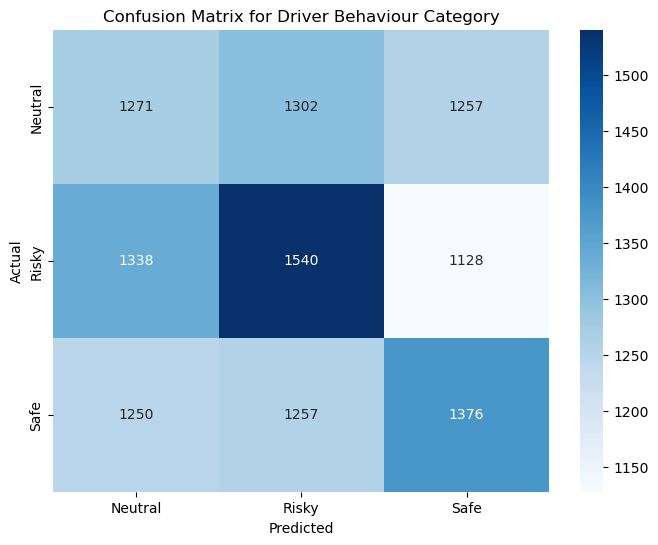


RMSE for premium prediction: 0.4430


C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Loading and Preprocessing
# Read the updated CSV file into a DataFrame
df_synthetic = pd.read_csv('synthetic_data_with_category.csv')

# Separate features and target for driver_behaviour_category prediction
X_cat = df_synthetic.drop(['driver_behaviour_category', 'driver_behaviour', 'premium', 'is_claim'], axis=1)
y_cat = df_synthetic['driver_behaviour_category']

# One-hot encode categorical features
X_cat_encoded = pd.get_dummies(X_cat)

# Split data into training and testing sets for driver_behaviour_category prediction
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat_encoded, y_cat, test_size=0.2, random_state=42)

# Separate features and target for premium prediction
X_reg = df_synthetic.drop(['driver_behaviour_category', 'driver_behaviour', 'premium', 'is_claim'], axis=1)
y_reg = df_synthetic['premium']

# One-hot encode categorical features
X_reg_encoded = pd.get_dummies(X_reg)

# Split data into training and testing sets for premium prediction
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg_encoded, y_reg, test_size=0.2, random_state=42)

# 2. Model Development
# 2.1 Driver Behaviour Category Prediction (Classification)
# Initialize and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_cat, y_train_cat)

# 2.2 Premium Estimation (Regression)
# Initialize and train a Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)

# 3. Model Evaluation
# 3.1 Driver Behaviour Category
# Predict on the test set
y_pred_cat = rf_classifier.predict(X_test_cat)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test_cat, y_pred_cat)
print(f"\nAccuracy for driver_behaviour_category prediction: {accuracy:.4f}")

# Display a confusion matrix
cm_cat = confusion_matrix(y_test_cat, y_pred_cat)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Driver Behaviour Category')
plt.show()

# 3.2 Premium Estimation
# Predict on the test set
y_pred_reg = rf_regressor.predict(X_test_reg)

# Evaluate the model using RMSE
rmse = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
print(f"\nRMSE for premium prediction: {rmse:.4f}")


In [13]:
#Hyperparameter Tuning for Random Forest (Step 1)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

# Assuming `df` is your DataFrame loaded from the CSV
# Read the updated CSV file into a DataFrame
df = pd.read_csv('synthetic_data_with_category.csv')

# For classification (driver_behaviour_category)
X_classification = df.drop(columns=['driver_behaviour_category', 'premium'])  # Features
y_classification = df['driver_behaviour_category']  # Target

# For regression (premium)
X_regression = df.drop(columns=['premium', 'driver_behaviour_category'])  # Features
y_regression = df['premium']  # Target

# Splitting the data into training and testing sets
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Now you can proceed with the GridSearchCV for hyperparameter tuning


# Define the parameter grid for Random Forest Classifier (for driver behavior prediction)
param_grid_classifier = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Define the parameter grid for Random Forest Regressor (for premium prediction)
param_grid_regressor = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the models
rf_classifier = RandomForestClassifier(random_state=42)
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV for both models
grid_search_classifier = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_classifier, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_regressor = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_regressor, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')

# Fit GridSearchCV for the classifier
grid_search_classifier.fit(X_train_classification, y_train_classification)

# Fit GridSearchCV for the regressor
grid_search_regressor.fit(X_train_regression, y_train_regression)

# Best parameters for the classifier
best_classifier_params = grid_search_classifier.best_params_
print("Best Classifier Parameters:", best_classifier_params)

# Best parameters for the regressor
best_regressor_params = grid_search_regressor.best_params_
print("Best Regressor Parameters:", best_regressor_params)

# Re-train the models with the best parameters
best_rf_classifier = grid_search_classifier.best_estimator_
best_rf_regressor = grid_search_regressor.best_estimator_

# Evaluate the models
# For Classifier
y_pred_classification = best_rf_classifier.predict(X_test_classification)
print("Classification Report:\n", classification_report(y_test_classification, y_pred_classification))
print("Confusion Matrix:\n", confusion_matrix(y_test_classification, y_pred_classification))

# For Regressor
y_pred_regression = best_rf_regressor.predict(X_test_regression)
print("RMSE:", mean_squared_error(y_test_regression, y_pred_regression, squared=False))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
269 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\JOELM\anaconda3\Lib\site-packa

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
575 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
287 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\JOELM\anaconda3\Lib\site-packa

Best Classifier Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Regressor Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


NameError: name 'classification_report' is not defined

In [15]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the models
# For Classifier
y_pred_classification = best_rf_classifier.predict(X_test_classification)
print("Classification Report:\n", classification_report(y_test_classification, y_pred_classification))
print("Confusion Matrix:\n", confusion_matrix(y_test_classification, y_pred_classification))

# For Regressor
y_pred_regression = best_rf_regressor.predict(X_test_regression)
print("RMSE:", mean_squared_error(y_test_regression, y_pred_regression, squared=False))


Classification Report:
               precision    recall  f1-score   support

     Neutral       1.00      1.00      1.00      3830
       Risky       1.00      1.00      1.00      4006
        Safe       1.00      1.00      1.00      3883

    accuracy                           1.00     11719
   macro avg       1.00      1.00      1.00     11719
weighted avg       1.00      1.00      1.00     11719

Confusion Matrix:
 [[3829    0    1]
 [   0 4006    0]
 [   0    0 3883]]
RMSE: 0.4012715653639939


C:\Users\JOELM\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Initialize models
lin_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()

# Train models
lin_reg.fit(X_train_regression, y_train_regression)
ridge_reg.fit(X_train_regression, y_train_regression)
lasso_reg.fit(X_train_regression, y_train_regression)

# Predict on the test set
lin_reg_preds = lin_reg.predict(X_test_regression)
ridge_reg_preds = ridge_reg.predict(X_test_regression)
lasso_reg_preds = lasso_reg.predict(X_test_regression)

# Evaluate models
def evaluate_model(predictions, actual):
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predictions)
    return mae, mse, rmse, r2

# Linear Regression Evaluation
lin_reg_eval = evaluate_model(lin_reg_preds, y_test_regression)

# Ridge Regression Evaluation
ridge_reg_eval = evaluate_model(ridge_reg_preds, y_test_regression)

# Lasso Regression Evaluation
lasso_reg_eval = evaluate_model(lasso_reg_preds, y_test_regression)

lin_reg_eval, ridge_reg_eval, lasso_reg_eval
